## Importación de Librerías ##

In [296]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import plotly.graph_objs as go
from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Lectura de los datos y solución de valores nulos #

In [297]:
df = pd.read_csv('files/weatherAUS.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145407  2017-06-20    Uluru      3.5     21.8       0.0          NaN   
145408  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145409  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145410  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145411  2017-06-24    Uluru      7.8     27.0       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  \
0            NaN           W           44.0          W  ...        22.0   
1            NaN         WNW           44.0        NNW  ...        25.0   
2            NaN         WSW           46.0          W  ...        30.0   
3            NaN          NE           24.0         SE  ...        16.0   
4            NaN           W           41.0        ENE  ...        33.0   
...          ...         ...            ...        ...  ...         ...   
145407       NaN           E           31.0        ESE  ...        27.0   
145408       NaN           E           31.0         SE  ...        24.0   
145409       NaN         NNW           22.0         SE  ...        21.0   
145410       NaN           N           37.0         SE  ...        24.0   
145411       NaN          SE           28.0        SSE  ...        24.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0            1007.7       1007.1       8.0       NaN     16.9     21.8   
1            1010.6       1007.8       NaN       NaN     17.2     24.3   
2            1007.6       1008.7       NaN       2.0     21.0     23.2   
3            1017.6       1012.8       NaN       NaN     18.1     26.5   
4            1010.8       1006.0       7.0       8.0     17.8     29.7   
...             ...          ...       ...       ...      ...      ...   
145407       1024.7       1021.2       NaN       NaN      9.4     20.9   
145408       1024.6       1020.3       NaN       NaN     10.1     22.4   
145409       1023.5       1019.1       NaN       NaN     10.9     24.5   
145410       1021.0       1016.8       NaN       NaN     12.5     26.1   
145411       1019.4       1016.5       3.0       2.0     15.1     26.0   

        RainToday  RainTomorrow  RainfallTomorrow  
0              No            No               0.0  
1              No            No               0.0  
2              No            No               0.0  
3              No            No               1.0  
4              No            No               0.2  
...           ...           ...               ...  
145407         No            No               0.0  
145408         No            No               0.0  
145409         No            No               0.0  
145410         No            No               0.0  
145411         No            No               0.0  

[145412 rows x 24 columns]

In [298]:
vacios_original=df.isna().sum()
vacios_original

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

## Clustering ##

Para solventar el problema de los datos vacíos decimos agrupar las ciudades en distintos clusters y completar aquellos datos vacíos con datos del mismo cluster para la misma fecha.

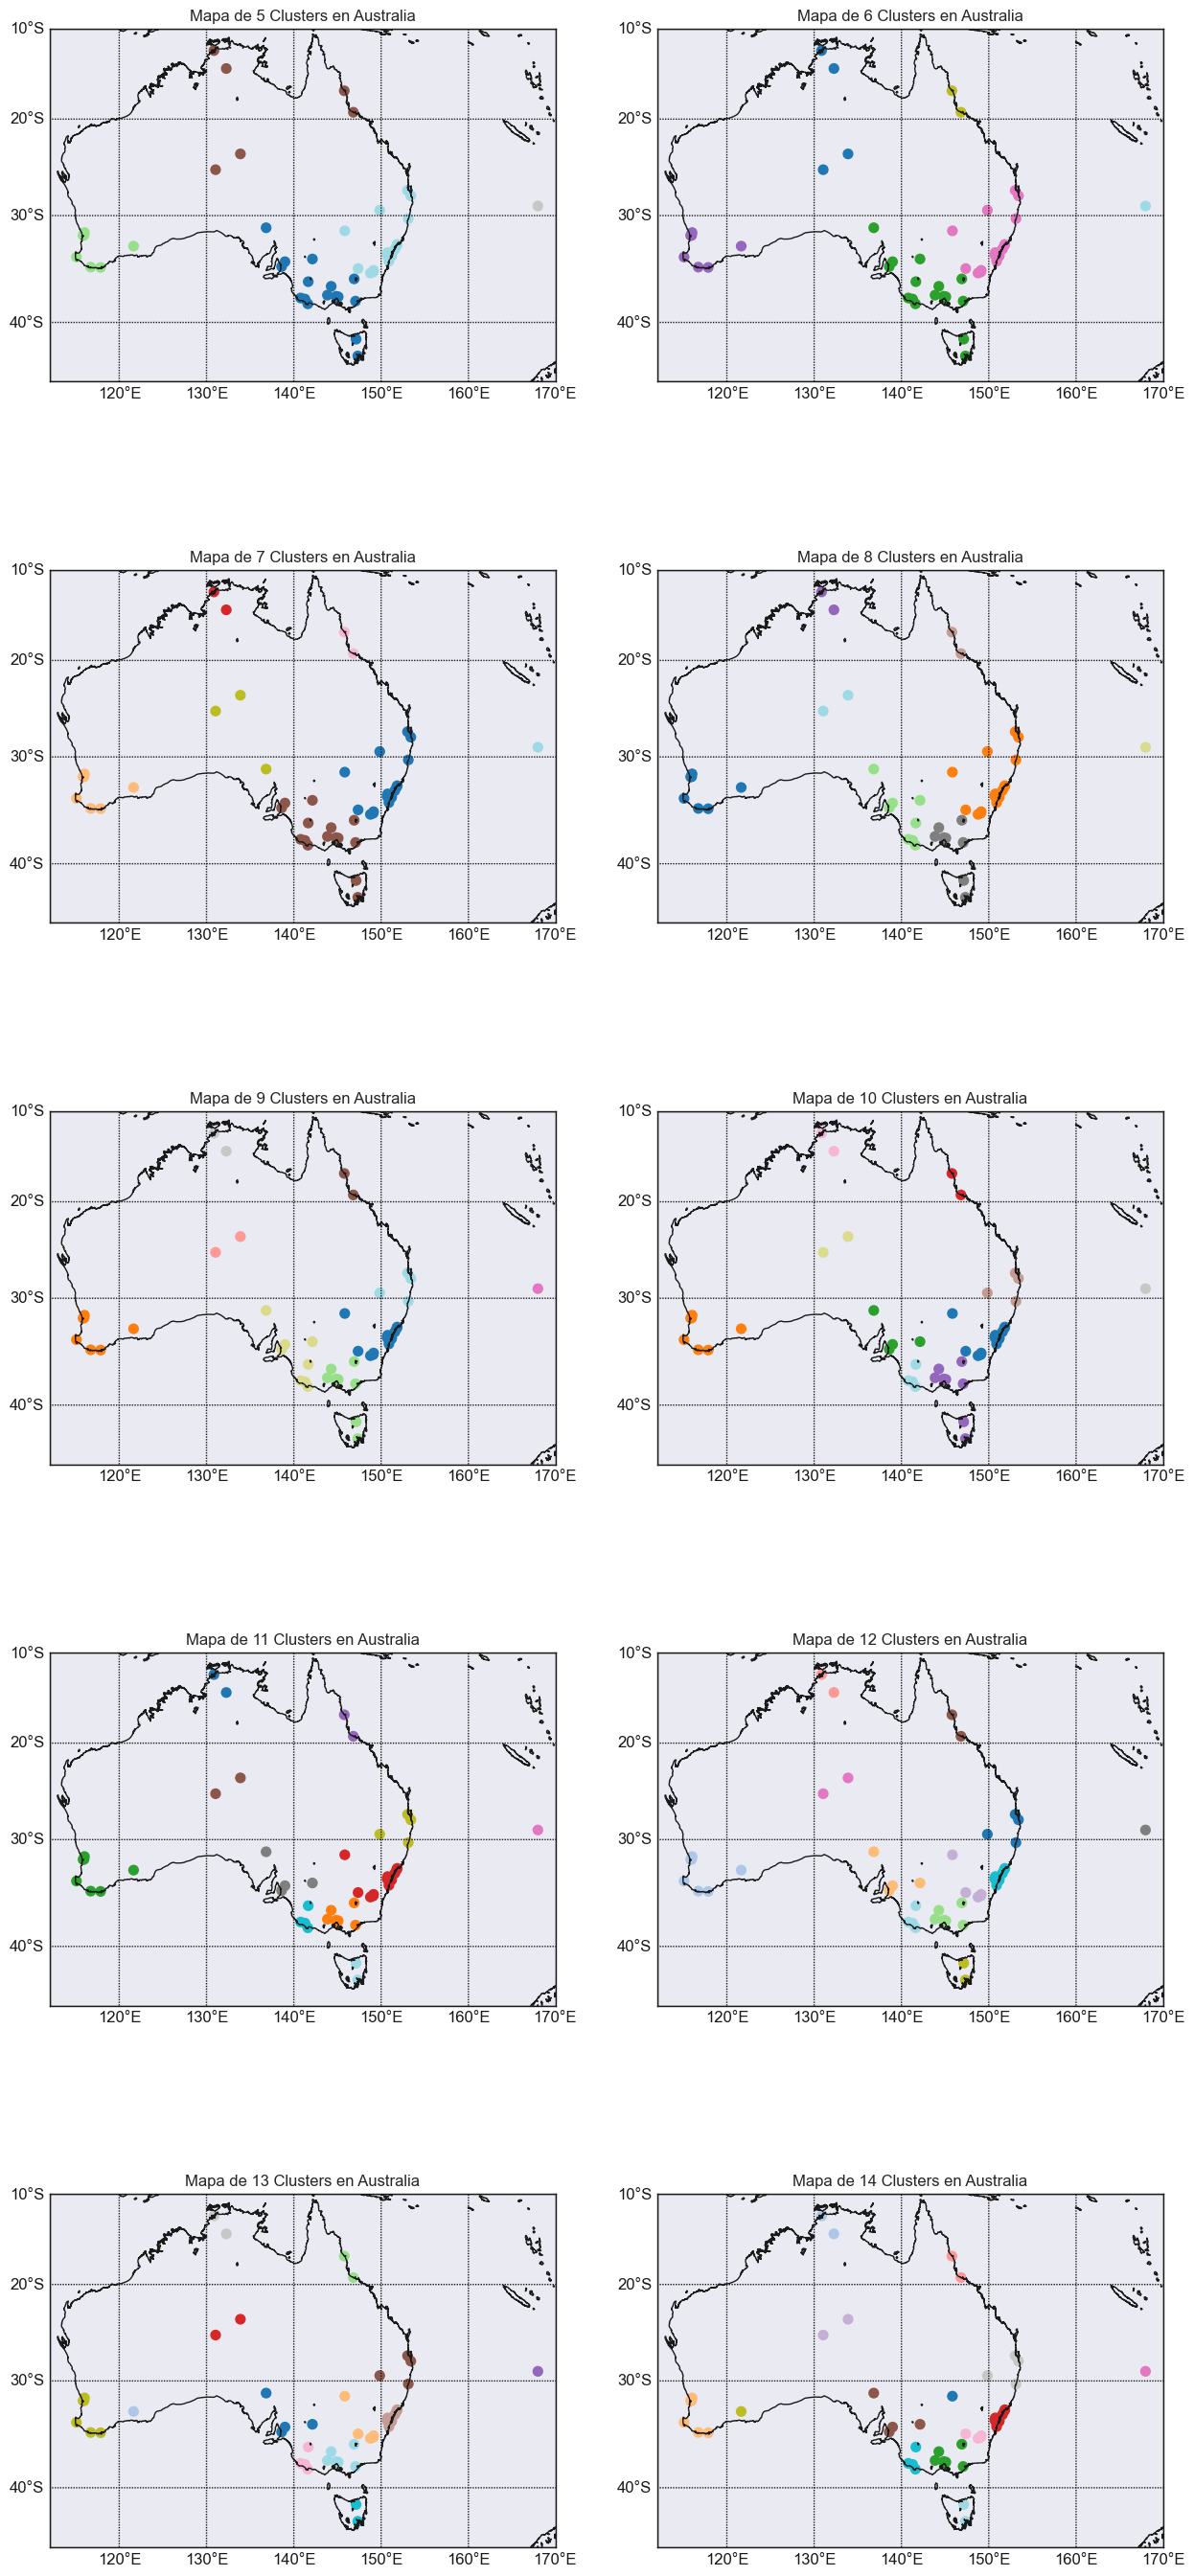

In [299]:
cities=df['Location'].unique().copy()
cities_coord = {'Adelaide': (-34.9285, 138.6007),
                'Albany': (-35.0031, 117.8657),
                'Albury': (-36.0737, 146.9135),
                'AliceSprings': (-23.6980, 133.8807),
                'BadgerysCreek': (-33.8813, 150.7400),
                'Ballarat': (-37.5622, 143.8503),
                'Bendigo': (-36.7570, 144.2794),
                'Brisbane': (-27.4698, 153.0251),
                'Cairns': (-16.9186, 145.7781),
                'Canberra': (-35.2809, 149.1300),
                'Cobar': (-31.4983, 145.8344),
                'CoffsHarbour': (-30.2963, 153.1131),
                'Dartmoor': (-37.9223, 141.2760),
                'Darwin': (-12.4634, 130.8456),
                'GoldCoast': (-28.0167, 153.4000),
                'Hobart': (-42.8821, 147.3272),
                'Katherine': (-14.4644, 132.2630),
                'Launceston': (-41.4545, 147.1317),
                'Melbourne': (-37.8136, 144.9631),
                'MelbourneAirport': (-37.6690, 144.8410),
                'Mildura': (-34.2083, 142.1270),
                'Moree': (-29.4638, 149.8413),
                'MountGambier': (-37.8241, 140.7798),
                'MountGinini': (-35.5294, 148.7720),
                'Newcastle': (-32.9283, 151.7817),
                'Nhil': (-36.3328, 141.6503),
                'NorahHead': (-33.2833, 151.5667),
                'NorfolkIsland': (-29.0408, 167.9547),
                'Nuriootpa': (-34.4667, 138.9833),
                'PearceRAAF': (-31.6675, 116.0158),
                'Penrith': (-33.7581, 150.6950),
                'Perth': (-31.9522, 115.8589),
                'PerthAirport': (-31.9405, 115.9660),
                'Portland': (-38.3511, 141.6056),
                'Richmond': (-33.6000, 150.7500),
                'Sale': (-38.1063, 147.0674),
                'SalmonGums': (-32.9819, 121.6431),
                'Sydney': (-33.8688, 151.2093),
                'SydneyAirport': (-33.9461, 151.1772),
                'Townsville': (-19.2583, 146.8169),
                'Tuggeranong': (-35.4244, 149.0887),
                'Uluru': (-25.3444, 131.0369),
                'WaggaWagga': (-35.1082, 147.3598),
                'Walpole': (-34.9772, 116.7317),
                'Watsonia': (-37.7114, 145.0831),
                'Williamtown': (-32.8150, 151.8428),
                'Witchcliffe': (-34.0264, 115.1000),
                'Wollongong': (-34.4241, 150.8931),
                'Woomera': (-31.1997, 136.8256)}

cities_coord = pd.DataFrame.from_dict(cities_coord, orient='index', columns=['lat', 'lon'])
cities_coord['mean_rain'] = df.groupby('Location')['Rainfall'].mean()
xPos=cities_coord[['lat','lon','mean_rain']].copy()
Nc= range(1, 20)
kmeans= [KMeans(n_clusters=i, n_init=10) for i in Nc]
score = [kmeans[i].fit(xPos).score(xPos) for i in range(len(kmeans))]
# plt.plot(Nc,score)
# plt.xlabel('NumberofClusters')
# plt.ylabel('Score')
# plt.title('ElbowCurve')
# plt.show()

num_clusters = range(5, 15)
num_rows = len(num_clusters) // 2 + len(num_clusters) % 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 7))
fig.subplots_adjust(hspace=0.3)

for i, num_cluster in enumerate(num_clusters):
    # Elegir el número óptimo de clusters
    kmeans = KMeans(n_clusters=num_cluster, n_init=10).fit(xPos)
    centroids = kmeans.cluster_centers_

    # Asignar cada punto a su respectivo cluster
    xPos['cluster'] = kmeans.predict(xPos)
    labels = np.unique(xPos['cluster'])
    palette = sns.color_palette("hot", len(labels))
    xPos['cluster'] = xPos['cluster'].astype('category')

    # Calcular la fila y la columna actual
    row = i // 2
    col = i % 2

    # Crear un mapa de Australia para el subplot actual
    ax = axes[row, col]
    m = Basemap(
        projection='merc',
        llcrnrlat=-45, urcrnrlat=-10,
        llcrnrlon=112, urcrnrlon=170,
        resolution='i',
        ax=ax
    )
    m.drawmapboundary()
    m.drawcoastlines()
    m.drawcountries()
    m.drawparallels(np.arange(-90., 91., 10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0, 0, 0, 1])

    # Crear un gráfico de dispersión centrado en Australia
    scatter = m.scatter(
        xPos['lon'], xPos['lat'],
        c=xPos['cluster'], cmap='tab20', s=50,
        latlon=True
    )

    # Configurar título y leyenda para el subplot
    ax.set_title(f'Mapa de {num_cluster} Clusters en Australia')
    #plt.colorbar(scatter, ax=ax, label='Cluster')

# Eliminar subplots vacíos si es necesario
if len(num_clusters) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.show()

Decidimos utilizar 11 clusters debido a que consideramos es la cantidad que mejor se ajusta a los datos sin hacer overfitting.

In [300]:
# Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=11, n_init=10).fit(xPos)
centroids = kmeans.cluster_centers_

# Asignar cada punto a su respectivo cluster
xPos['cluster'] = kmeans.predict(xPos)
labels = np.unique(xPos['cluster'])
palette = sns.color_palette("hot", len(labels))
xPos['cluster'] = xPos['cluster'].astype('category')

df['Cluster']=df['Location'].map(xPos['cluster'])
df.to_csv('files/weatherAUS_cluster.csv', index=False)

## Corrigiendo datos vacíos ##

Dado que estamos hablando de variables climáticas y se puede considerar que estan no presentan grandes variaciones para regiones cercanas, al clusterizar las ciudades podemos estimar aquellos datos vacíos como la media de los datos de las ciudades del mismo cluster para la misma fecha.

In [301]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
non_numeric_columns = df.select_dtypes(include=[object]).columns

In [302]:
# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la media del grupo
df_numeric = df.groupby(['Cluster', 'Date'])[numeric_columns].transform(lambda x: x.fillna(x.mean()))

# Asignar los valores llenos al DataFrame original
df[numeric_columns] = df_numeric

# Función para llenar los valores nulos con la moda
def fill_with_mode(x):
    mode_value = x.mode()
    if len(mode_value) > 0:
        return x.fillna(mode_value.iloc[0])
    else:
        return x

# Agrupar por 'Cluster' y 'Date' y llenar los valores nulos con la moda del grupo
df_non_numeric = df.groupby(['Cluster', 'Date'])[non_numeric_columns].transform(fill_with_mode)

# Asignar los valores llenos al DataFrame original
df[non_numeric_columns] = df_non_numeric

In [303]:
vacios_transformado=df.isna().sum()
comparison_df = pd.DataFrame({'vacios_antes': vacios_original, 'vacios_despues': vacios_transformado})
total_datos = len(df)
comparison_df['porcentaje recuperado'] = 100 * (1 - comparison_df['vacios_despues'] / comparison_df['vacios_antes'])
comparison_df['porcentaje recuperado'] = comparison_df['porcentaje recuperado'].apply(lambda x: f'{x:.2f}%')
comparison_df['porcentaje_completo'] = 100 * (1 - comparison_df['vacios_despues'] / total_datos)
comparison_df['porcentaje_completo'] = comparison_df['porcentaje_completo'].apply(lambda x: f'{x:.2f}%')


# Mostrar el DataFrame con la comparación
comparison_df

vacios_antes  vacios_despues porcentaje recuperado  \
Cloud3pm               59336.0            1867                96.85%   
Cloud9am               55870.0            1528                97.27%   
Cluster                    NaN               0                  nan%   
Date                       0.0               0                  nan%   
Evaporation            62754.0            1524                97.57%   
Humidity3pm             4505.0               9                99.80%   
Humidity9am             2653.0               9                99.66%   
Location                   0.0               0                  nan%   
MaxTemp                 1253.0               4                99.68%   
MinTemp                 1484.0               3                99.80%   
Pressure3pm            15024.0               6                99.96%   
Pressure9am            15061.0              11                99.93%   
RainToday               3260.0              66                97.98%   
RainTomorrow            3259.0              66                97.97%   
Rainfall                3260.0              66                97.98%   
RainfallTomorrow        3259.0              66                97.97%   
Sunshine               69796.0            4148                94.06%   
Temp3pm                 3607.0               6                99.83%   
Temp9am                 1766.0               6                99.66%   
WindDir3pm              4226.0              15                99.65%   
WindDir9am             10562.0             224                97.88%   
WindGustDir            10316.0             426                95.87%   
WindGustSpeed          10253.0             424                95.86%   
WindSpeed3pm            3061.0               9                99.71%   
WindSpeed9am            1767.0              19                98.92%   

                 porcentaje_completo  
Cloud3pm                      98.72%  
Cloud9am                      98.95%  
Cluster                      100.00%  
Date                         100.00%  
Evaporation                   98.95%  
Humidity3pm                   99.99%  
Humidity9am                   99.99%  
Location                     100.00%  
MaxTemp                      100.00%  
MinTemp                      100.00%  
Pressure3pm                  100.00%  
Pressure9am                   99.99%  
RainToday                     99.95%  
RainTomorrow                  99.95%  
Rainfall                      99.95%  
RainfallTomorrow              99.95%  
Sunshine                      97.15%  
Temp3pm                      100.00%  
Temp9am                      100.00%  
WindDir3pm                    99.99%  
WindDir9am                    99.85%  
WindGustDir                   99.71%  
WindGustSpeed                 99.71%  
WindSpeed3pm                  99.99%  
WindSpeed9am                  99.99%

Podemos notar que el método fue efectivo, habiendo recuperado grandes cantidades de datos y con registros totales completos que se acercan al 100%. Ahora podríamos considerar eliminar los registros que presenten valores nulos y no deberíamos perder grandes vólumenes de información.

In [304]:
df_sin_nan = df.dropna()
df_sin_nan.to_csv('files/weatherAUS_sin_nan.csv', index=False)
df=df_sin_nan.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139738 entries, 0 to 144987
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              139738 non-null  datetime64[ns]
 1   Location          139738 non-null  object        
 2   MinTemp           139738 non-null  float64       
 3   MaxTemp           139738 non-null  float64       
 4   Rainfall          139738 non-null  float64       
 5   Evaporation       139738 non-null  float64       
 6   Sunshine          139738 non-null  float64       
 7   WindGustDir       139738 non-null  object        
 8   WindGustSpeed     139738 non-null  float64       
 9   WindDir9am        139738 non-null  object        
 10  WindDir3pm        139738 non-null  object        
 11  WindSpeed9am      139738 non-null  float64       
 12  WindSpeed3pm      139738 non-null  float64       
 13  Humidity9am       139738 non-null  float64       
 14  Humi

## Unificando Variables relacionadas ##

Existen relaciones intrínsecas entre ciertas variables, para poder hacer predicciones con ellas decidimos unificarlas en otras nuevas. Construimos un vector para aquellas variables que presentaban módulo y dirección, para luego tomar sus componentes como nuevos parámetros. Tomamos la diferencia de presiones también como nueva variable, el mismo procedimiento lo hacemos para la humedad. Para las variables de nubosidad construimos una nueva variable categórica que representara el estado del cielo en ese día.

In [305]:
def vector_coordinates(df,column,dir,speed):
    direcciones = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5
    }
    velocidad=df[speed]
    df[column+'u'] = -velocidad * np.sin(np.deg2rad(df[dir].map(direcciones)))
    df[column+'v'] = -velocidad * np.cos(np.deg2rad(df[dir].map(direcciones)))
    return df

def definir_estado_del_cielo(row):
    if row['Cloud9am'] == 0 and row['Cloud3pm'] == 0:
        return 'Despejado'
    elif row['Cloud9am'] <= 4 and row['Cloud3pm'] <= 4:
        return 'Parcialmente Nublado'
    elif row['Cloud9am'] <= 7 and row['Cloud3pm'] <= 7:
        return 'Nublado'
    else:
        return 'Muy Nublado'

In [306]:
df=vector_coordinates(df,'Wind9am','WindDir9am','WindSpeed9am')
df=vector_coordinates(df,'Wind3pm','WindDir3pm','WindSpeed3pm')
df=vector_coordinates(df,'WindGust','WindGustDir','WindGustSpeed')
df['Pressure_Difference'] = df['Pressure3pm'] - df['Pressure9am']
df['Humidity_Difference'] = df['Humidity3pm'] - df['Humidity9am']
df['Estado_Cielo'] = df.apply(definir_estado_del_cielo, axis=1)
df.drop(['Cloud3pm','Cloud9am','Humidity3pm','Humidity9am','WindSpeed9am','WindSpeed3pm','WindGustSpeed','WindDir9am','WindDir3pm','WindGustDir','Pressure3pm','Pressure9am','Temp3pm','Temp9am'], axis=1, inplace=True)
df

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0      2008-12-01   Albury     13.4     22.9       0.6          7.3      10.1   
1      2008-12-02   Albury      7.4     25.1       0.0          7.8       7.5   
2      2008-12-03   Albury     12.9     25.7       0.0          5.9       6.7   
3      2008-12-04   Albury      9.2     28.0       0.0          5.8       5.8   
4      2008-12-05   Albury     17.5     32.3       1.0          6.3      13.4   
...           ...      ...      ...      ...       ...          ...       ...   
144981 2016-04-20    Uluru     18.8     31.7       0.0          8.0       9.9   
144984 2016-04-23    Uluru     16.9     28.4       0.0         18.4      11.0   
144985 2016-04-24    Uluru     12.1     27.3       0.0          8.2      11.0   
144986 2016-04-25    Uluru      9.6     28.8       0.0          7.8      11.0   
144987 2016-04-26    Uluru     11.0     32.5       0.0          8.0      11.0   

       RainToday RainTomorrow  RainfallTomorrow Cluster      Wind9amu  \
0             No           No               0.0       5  2.000000e+01   
1             No           No               0.0       5  1.530734e+00   
2             No           No               0.0       5  1.900000e+01   
3             No           No               1.0       5 -7.778175e+00   
4             No           No               0.2       5 -6.467157e+00   
...          ...          ...               ...     ...           ...   
144981        No           No               0.0       8 -2.081900e-15   
144984        No           No               0.0       8 -1.847759e+01   
144985        No           No               0.0       8 -2.032535e+01   
144986        No           No               0.0       8 -1.300000e+01   
144987        No           No               0.0       8 -1.100000e+01   

            Wind9amv   Wind3pmu      Wind3pmv  WindGustu     WindGustv  \
0       3.673940e-15  22.173109 -9.184402e+00  44.000000  8.082669e-15   
1      -3.695518e+00  20.325350  8.419036e+00  40.650699 -1.683807e+01   
2       3.490243e-15  24.020868  9.949769e+00  42.498458  1.760344e+01   
3       7.778175e+00  -9.000000 -5.510911e-16 -16.970563 -1.697056e+01   
4      -2.678784e+00  14.142136 -1.414214e+01  41.000000  7.531578e-15   
...              ...        ...           ...        ...           ...   
144981  1.700000e+01 -13.435029 -1.343503e+01  11.863186  2.864027e+01   
144984  7.653669e+00 -18.477591  7.653669e+00 -31.000000 -1.898203e-15   
144985 -8.419036e+00 -19.000000 -1.163414e-15 -31.000000 -1.898203e-15   
144986 -7.960204e-16  -3.444151 -8.314916e+00 -30.000000 -1.836970e-15   
144987 -6.735557e-16  16.970563 -1.697056e+01  -0.000000 -3.300000e+01   

        Pressure_Difference  Humidity_Difference          Estado_Cielo  
0                      -0.6                -49.0           Muy Nublado  
1                      -2.8                -19.0               Nublado  
2                       1.1                 -8.0               Nublado  
3                      -4.8                -29.0           Muy Nublado  
4                      -4.8                -49.0           Muy Nublado  
...                     ...                  ...                   ...  
144981                 -2.8                -20.0           Muy Nublado  
144984                 -4.4                -20.0  Parcialmente Nublado  
144985                 -4.8                -21.0             Despejado  
144986                 -4.6                -15.0             Despejado  
144987                 -4.9                -16.0  Parcialmente Nublado  

[139738 rows x 20 columns]

# Visualización y análisis de datos #

In [307]:
def city_dataframe(city):
    df_city = df[df['Location'] == city]
    return df_city

def cluster_dataframe(df,cluster):
    df_cluster = df[df['Cluster'] == cluster]
    return df_cluster

def plot_temperature(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 5))
    sns.lineplot(x="Date", y="MaxTemp", data=df, color='red')
    sns.lineplot(x="Date", y="MinTemp", data=df, color='blue')
    plt.xticks(rotation=90)
    plt.xticks(np.arange(0, len(df), 50))
    plt.show()

def plot_variables(df):
    sns.set(style="darkgrid")

    # Obtiene una lista de todas las columnas numéricas del DataFrame
    numeric_columns = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=[float, int]).columns

    # Calcula el número de filas y columnas necesarias para el ploteo
    num_rows = (len(numeric_columns) + 1) // 2
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_rows, 20 * num_cols))

    # Espacio entre los subplots
    plt.subplots_adjust(wspace=1, hspace=1)

    # Colores distintos para los histogramas
    colors = sns.color_palette("Set2", n_colors=len(numeric_columns))

    # Itera a través de las columnas numéricas y crea un histograma para cada una
    for i, col in enumerate(numeric_columns):
        row = i // num_cols
        col_idx = i % num_cols

        # Selecciona un color diferente para cada histograma
        color = colors[i]

        sns.histplot(data=df, x=col, kde=True, color=color, ax=axs[row, col_idx])

        axs[row, col_idx].set_xlabel(col, fontsize=30)
        axs[row, col_idx].set_ylabel("Count",fontsize=20)

        # Cambia el tamaño de letra de los ejes X y Y
        axs[row, col_idx].tick_params(axis='x', labelsize=20)
        axs[row, col_idx].tick_params(axis='y', labelsize=20)

    # Elimina cualquier subplot no utilizado
    for i in range(len(numeric_columns), num_rows * num_cols):
        row = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axs[row, col_idx])

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        fig.suptitle(f"Histogramas de variales numéricas: {df['Location'].iloc[0]}", fontsize=30)
    else:
        fig.suptitle(f"Histogramas de variales numéricas", fontsize=30)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def matriz_correlacion(df):
    corr = df.select_dtypes(include=[float, int]).corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 15))

    ax = sns.heatmap(
        corr,
        #mask = mask,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot=True,
        annot_kws={'size': 15},
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

    # Añade un título general a la figura
    if len(df['Cluster'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación para el Cluster: {df['Cluster'].iloc[0]}", fontsize=30)
    elif len(df['Location'].unique()) == 1:
        ax.set_title(f"Matriz de Correlación: {df['Location'].iloc[0]}", fontsize=30)
    else:
        ax.set_title("Matriz de Correlación", fontsize=30)
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para el título general
    plt.show()

def global_boxplots(df):
    # Asegúrate de que todas las columnas sean numéricas
    columnas_numericas = df.drop(['Rainfall','RainfallTomorrow'],axis=1).select_dtypes(include=['number'])
    
    if columnas_numericas.empty:
        print("No hay columnas numéricas en el DataFrame.")
        return
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title("Boxplots para todas las variables")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()

def date_boxplots(df, year, month):
    # Asegúrate de que la columna 'Date' sea de tipo datetime
    df1 = df.drop(['Rainfall','RainfallTomorrow'],axis=1).copy()  # Realizar una copia del DataFrame para evitar el SettingWithCopyWarning

    # Filtrar el DataFrame por el año y el mes específicos
    filtered_df1 = df1[(df1['Date'].dt.year == year) & (df1['Date'].dt.month == month)]
    
    if filtered_df1.empty:
        print("No hay datos para el año y mes especificados.")
        return
    
    # Seleccionar solo las columnas numéricas
    columnas_numericas = filtered_df1.select_dtypes(include=['number'])
    
    # Normalizar las columnas numéricas
    scaler = StandardScaler()
    columnas_numericas_normalized = pd.DataFrame(scaler.fit_transform(columnas_numericas), columns=columnas_numericas.columns)
    
    # Obtener la cantidad de datos disponibles
    cantidad_datos = len(filtered_df1)
    
    # Crear una lista de títulos de columnas rotados
    column_titles = [col for col in columnas_numericas_normalized.columns]
    
    # Graficar los boxplots de las columnas numéricas normalizadas con rango en el eje Y de -4 a 4
    plt.figure(figsize=(20, 10))
    plt.title(f"Boxplots para {year}/{month}")
    boxplot = plt.boxplot(columnas_numericas_normalized.values, vert=True)
    
    # Rotar los títulos de las columnas
    plt.xticks(range(1, len(columnas_numericas_normalized.columns) + 1), column_titles, rotation=90)
    
    plt.xlabel("Variables")
    plt.ylabel("Valores Normalizados")
    plt.ylim(-4, 4)  # Establecer el rango en el eje Y
    plt.show()


def scatter_plot(df):
    numeric_cols = df.drop(['RainfallTomorrow'], axis=1).select_dtypes(include=['number'])
    num_plots = len(numeric_cols.columns)
    
    # Determina el número de filas y columnas para la matriz
    num_rows = (num_plots + 2) // 3  # Redondea hacia arriba
    num_cols = min(num_plots, 3)

    # Aumenta el tamaño de la figura
    figsize = (20, num_rows * 6)  # Aumenta la altura de la figura
    
    # Crea una figura de Matplotlib con subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    for i, col in enumerate(numeric_cols.columns):
        row = i // num_cols
        col_num = i % num_cols  # Cambia el nombre de la variable para evitar la confusión

        # Selecciona el subplot actual
        ax = axes[row, col_num]

        # Crea el gráfico de dispersión en el subplot
        sns.scatterplot(x=col, y='RainfallTomorrow', data=df, hue='Cluster', ax=ax)
        ax.set_title(col)  # Configura el título del subplot

    # Elimina subplots no utilizados
    for i in range(num_plots, num_rows * num_cols):
        row = i // num_cols
        col_num = i % num_cols
        fig.delaxes(axes[row, col_num])

    plt.tight_layout()
    plt.show()
    
def graficos(df):
    # Imprimir la cantidad de datos disponibles
    print(f"Cantidad de datos disponibles en el DataFrame: {len(df)}")
    plot_variables(df)
    matriz_correlacion(df)
    global_boxplots(df)
    scatter_plot(df)

Usamos la función gráfico para plotear distintos gráficos para el dataframe.

Cantidad de datos disponibles en el DataFrame: 139738


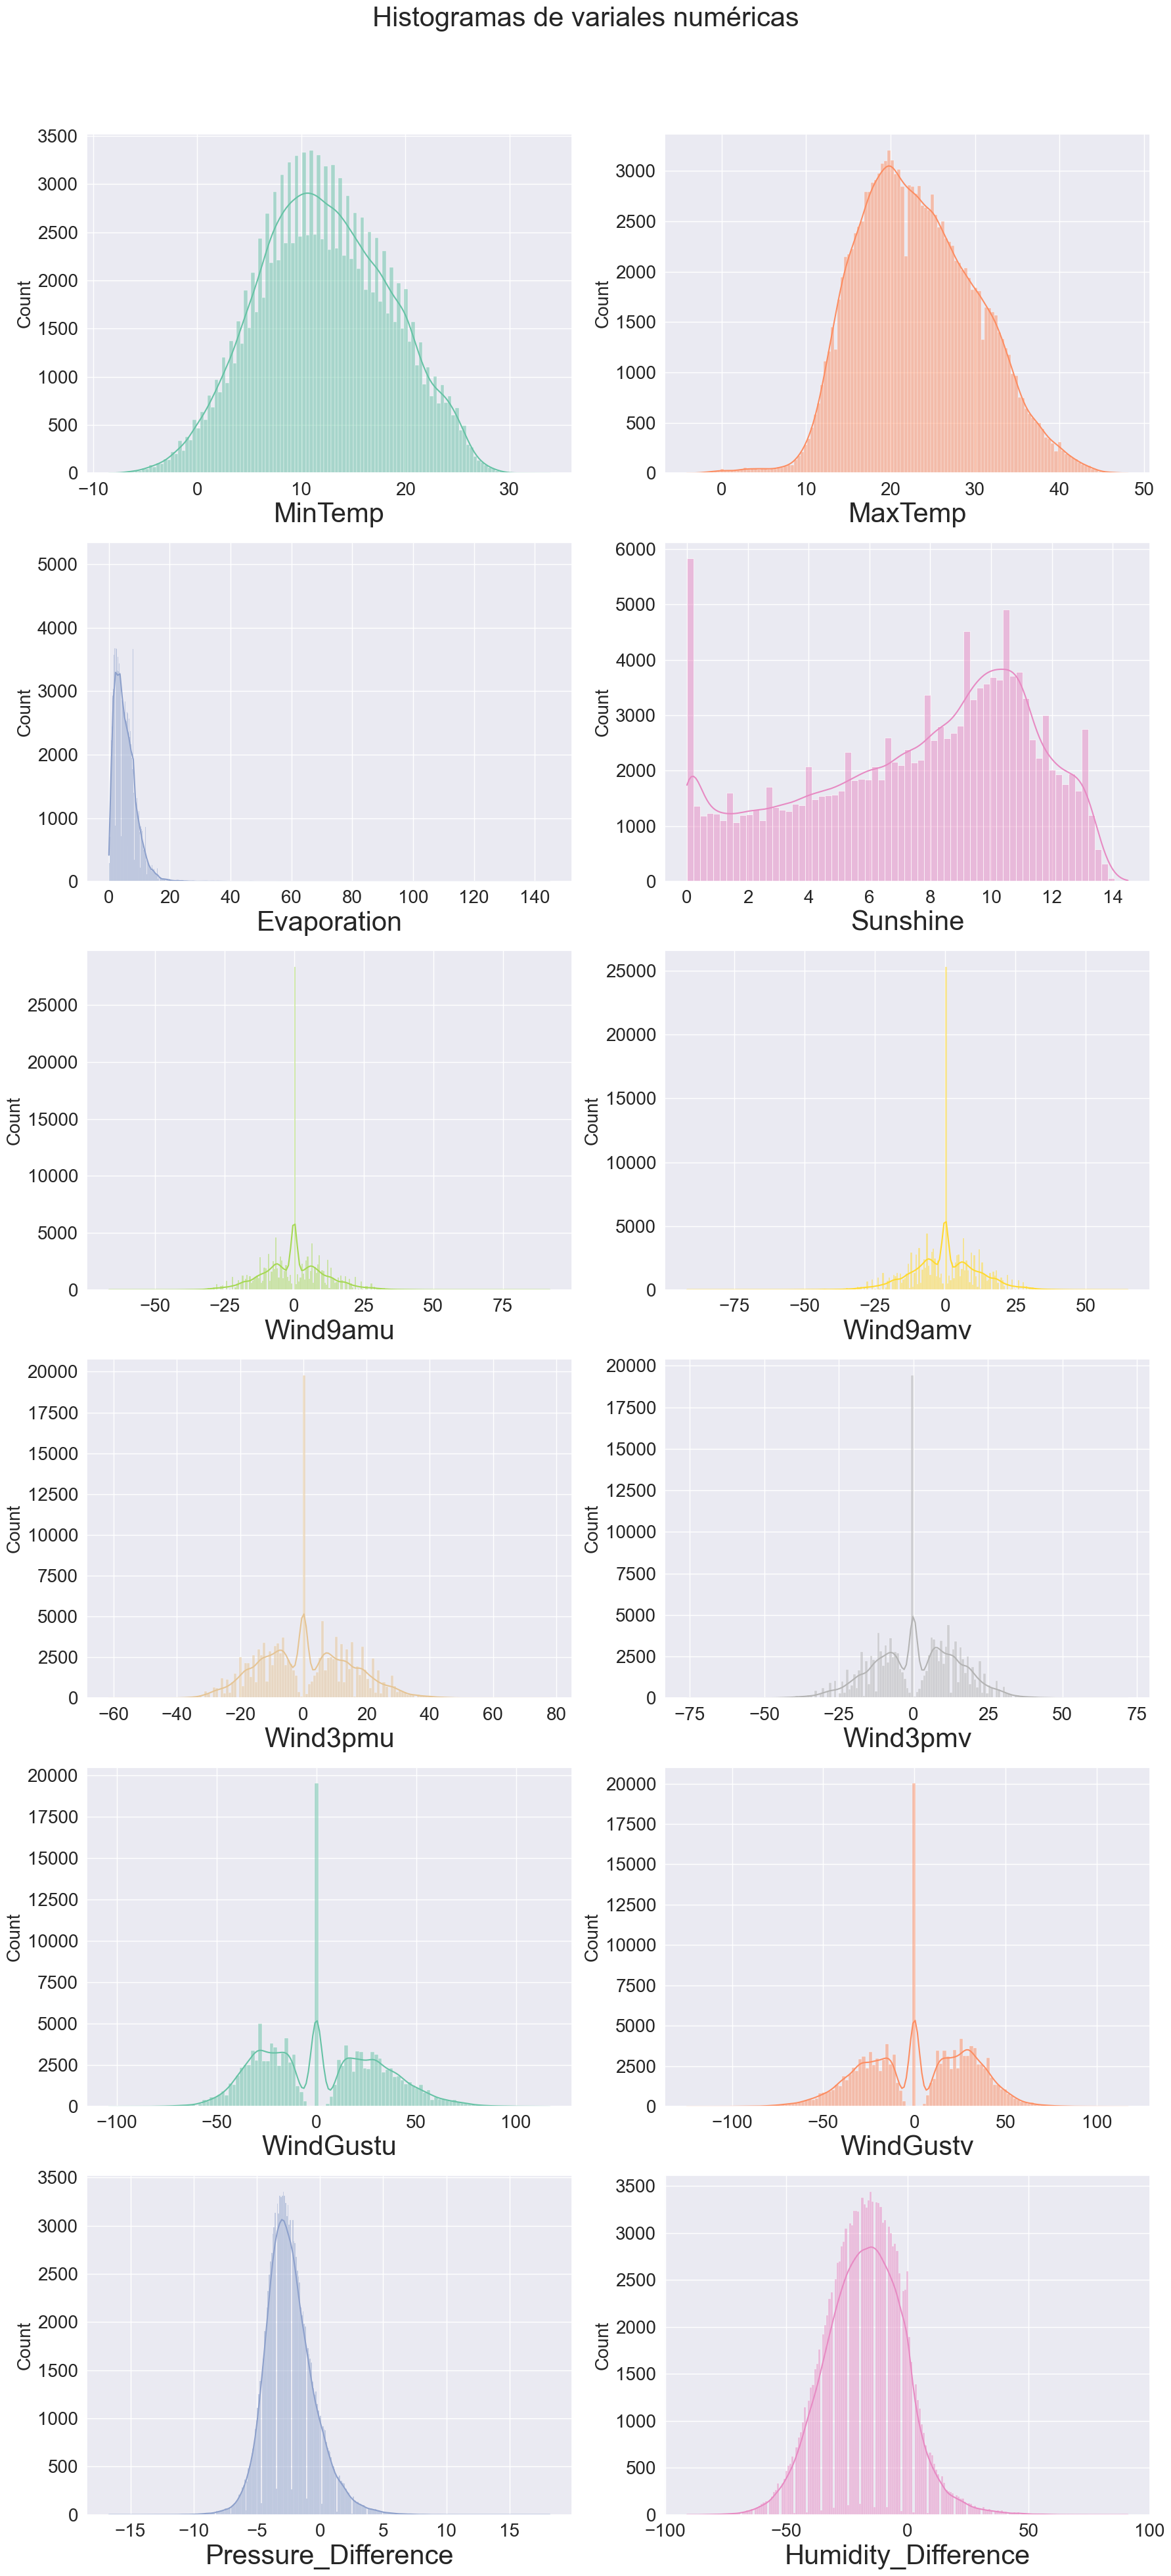

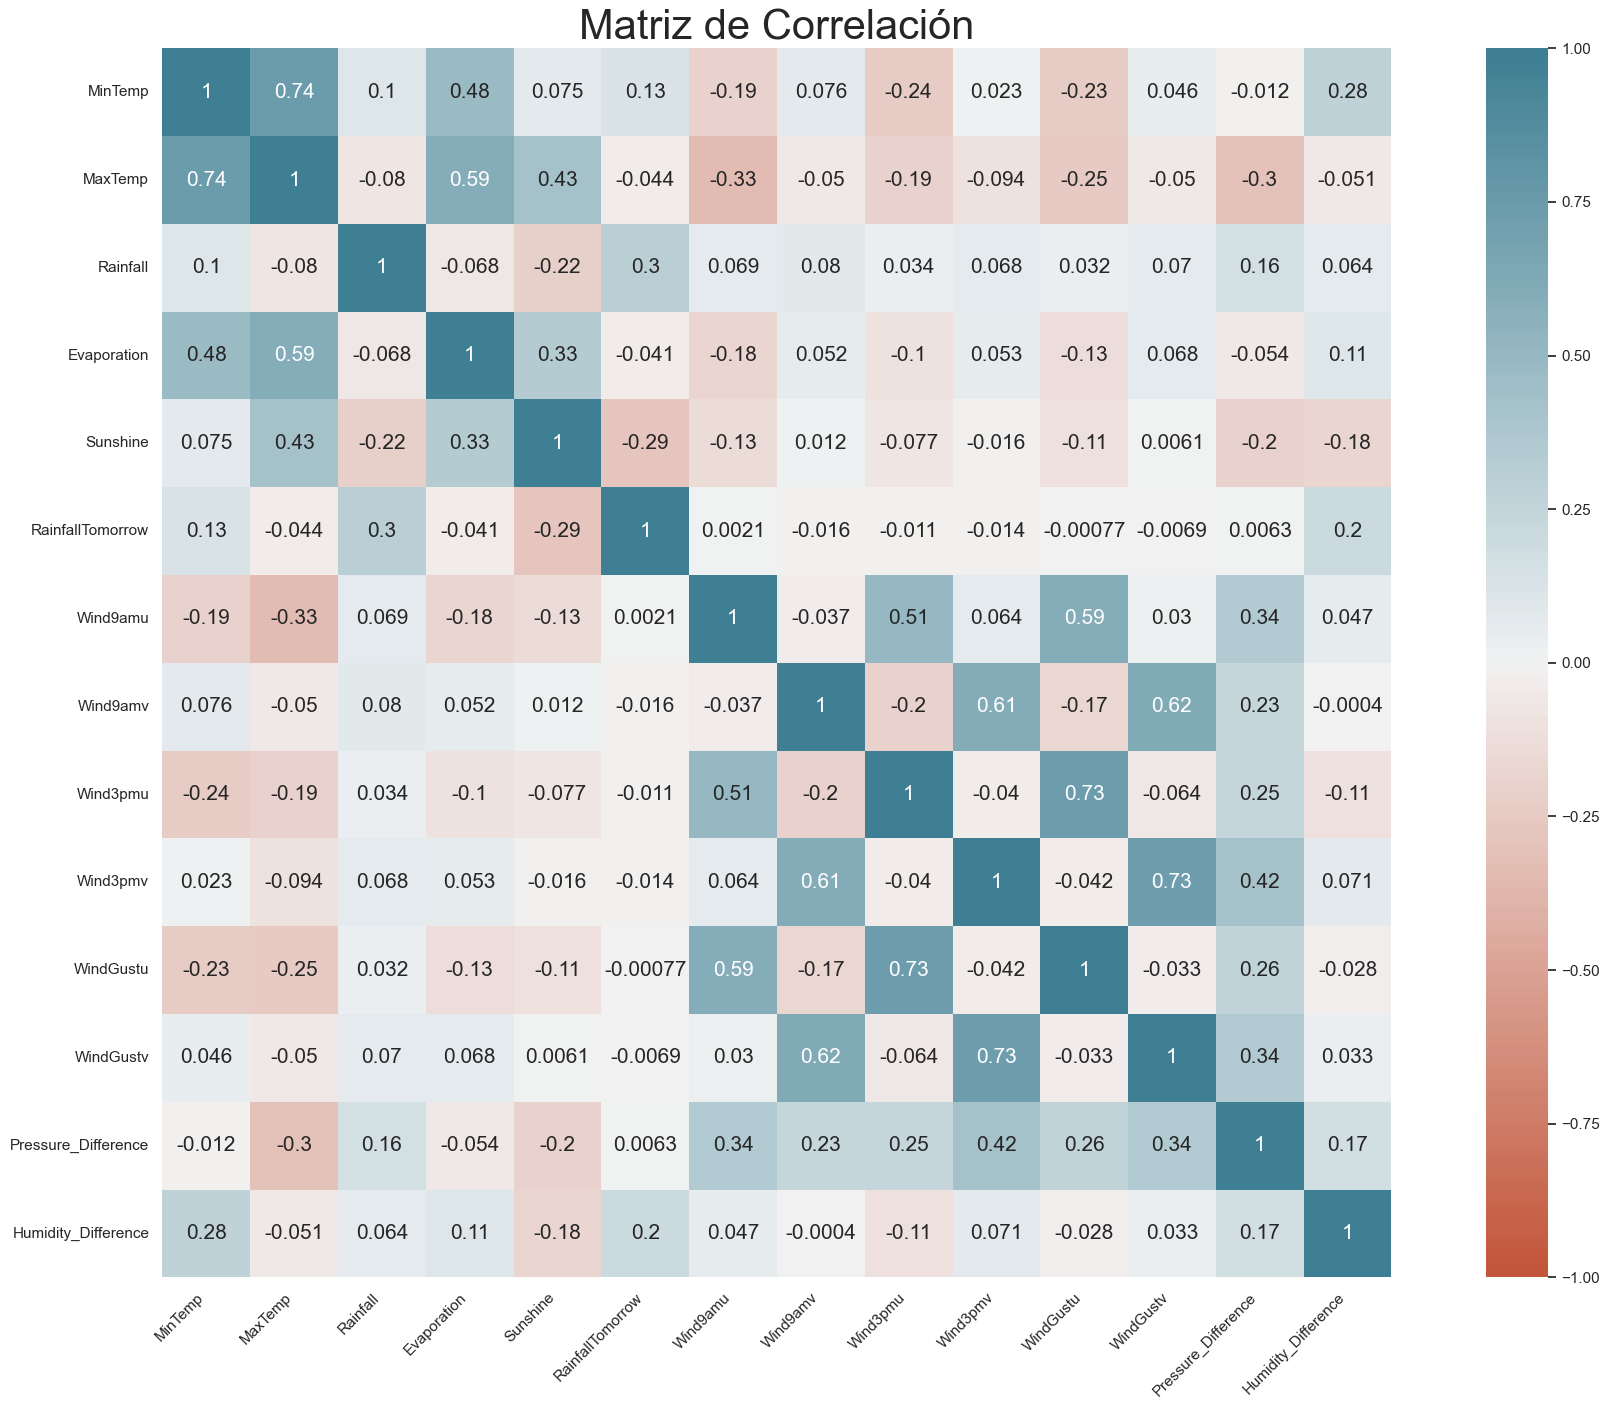

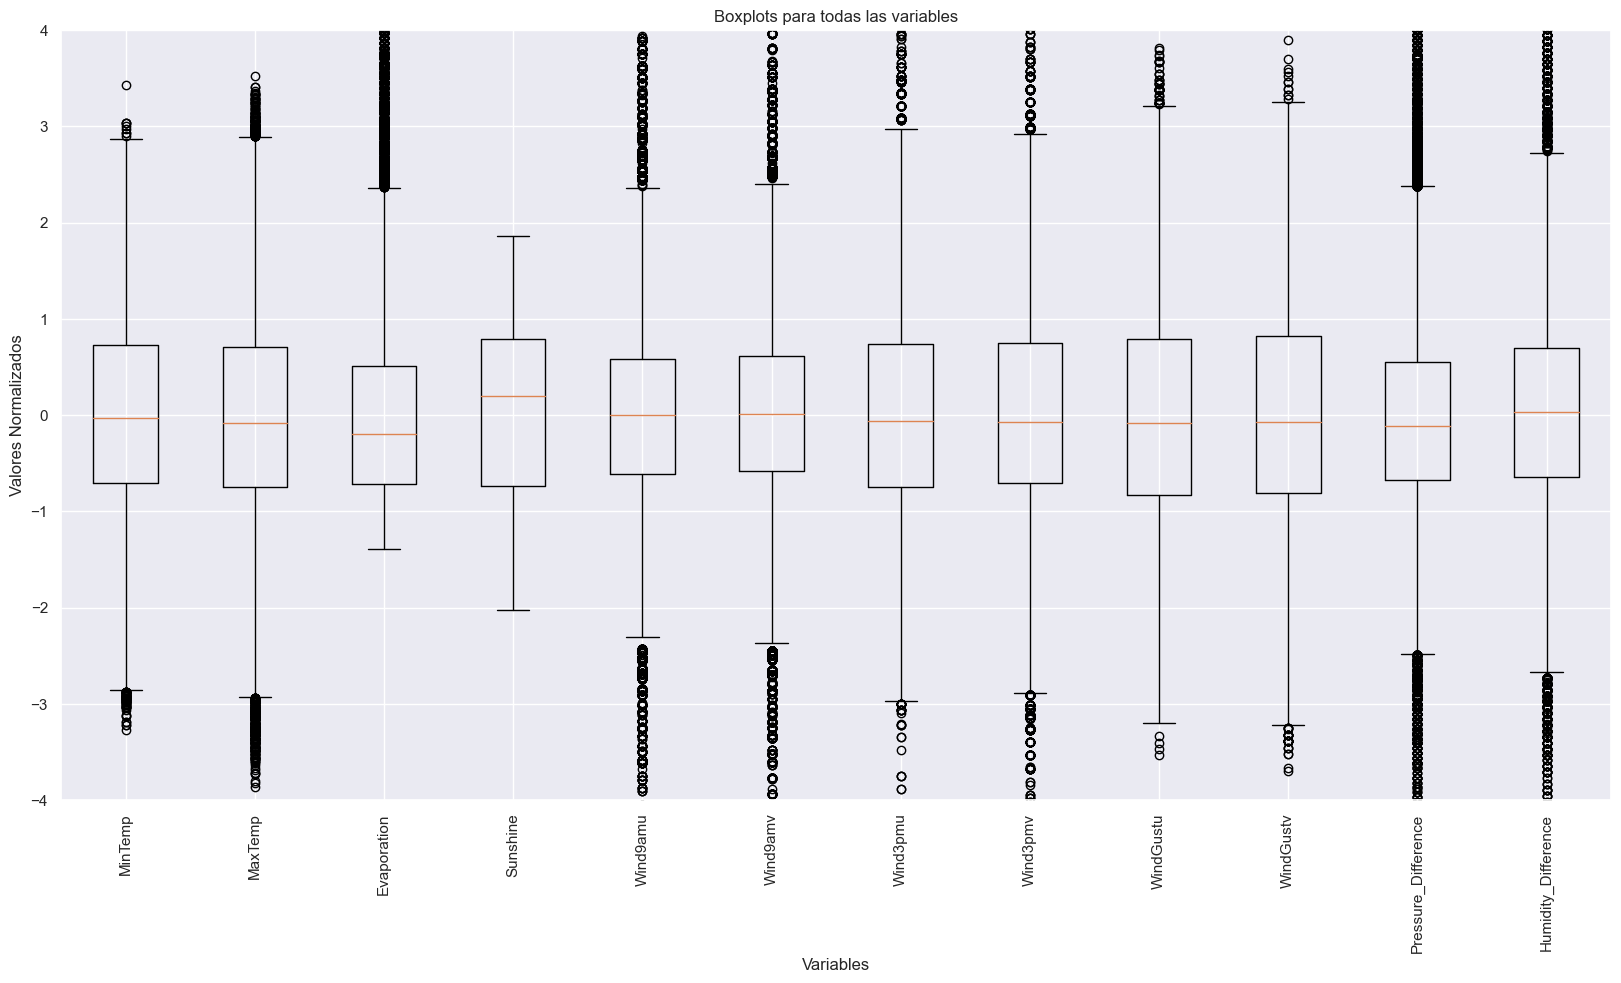

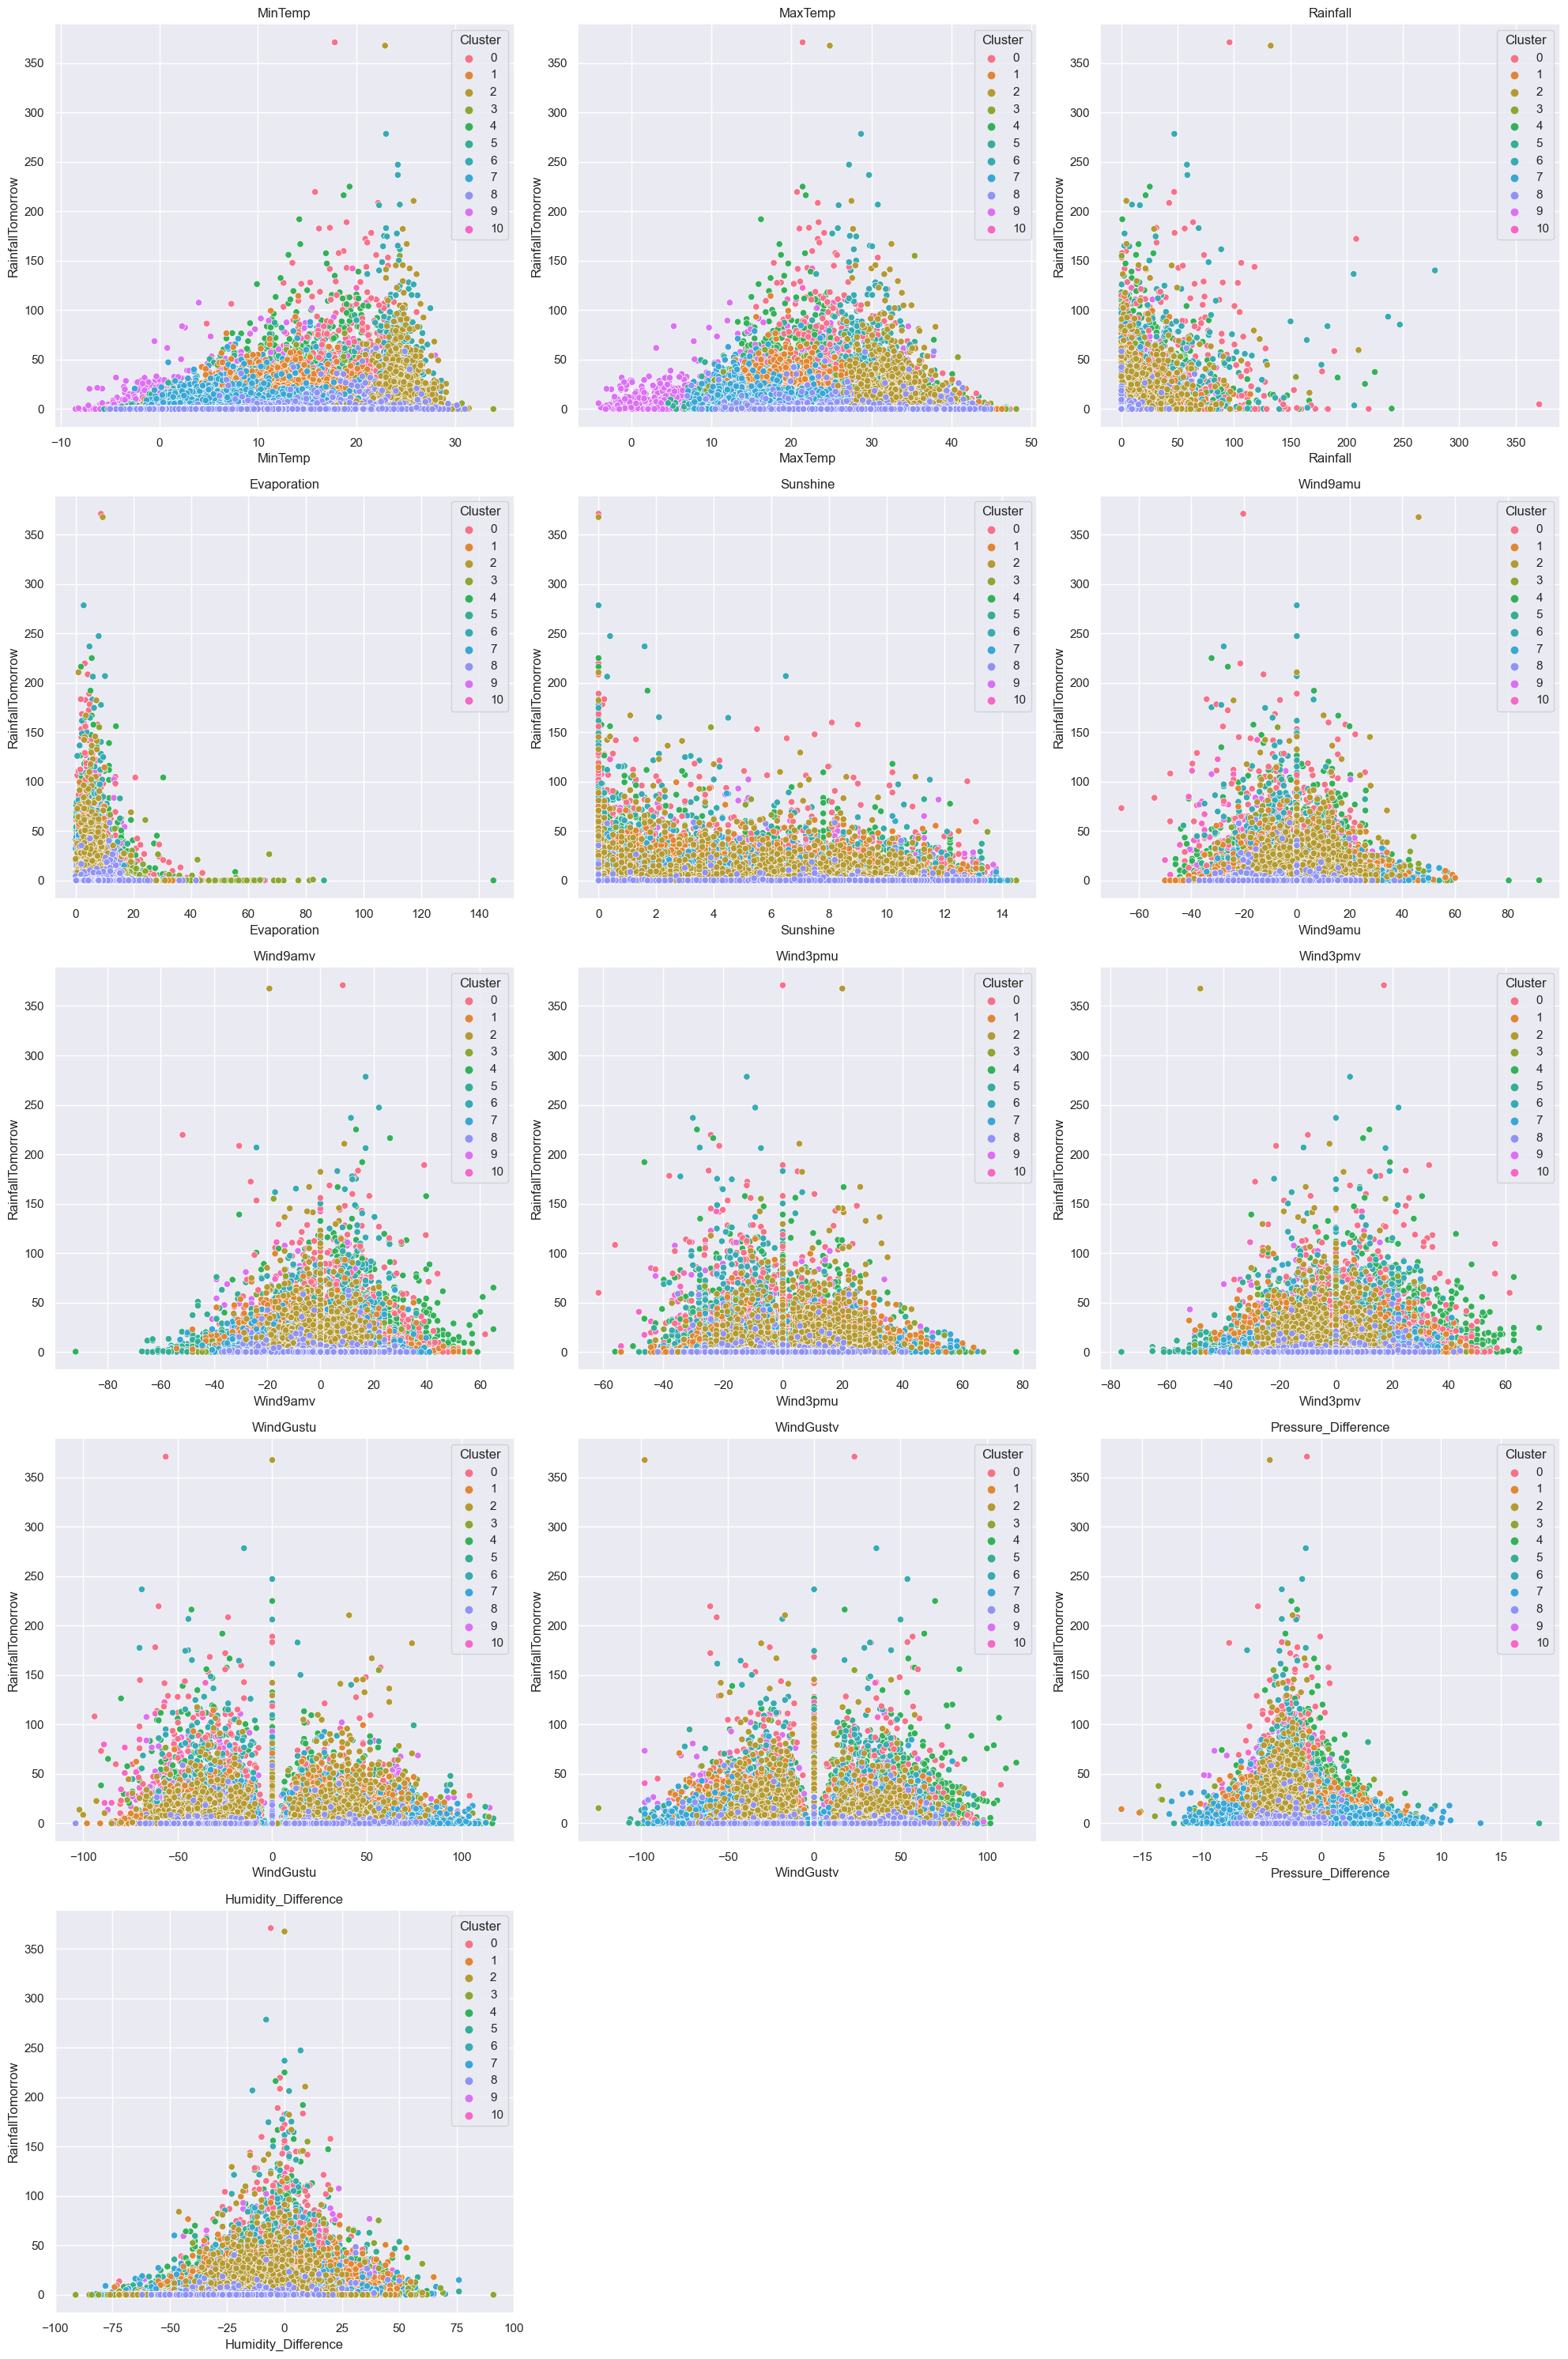

In [308]:
graficos(df)

Podemos usar la misma función para visualizar los datos de un cluster particular.

Cantidad de datos disponibles en el DataFrame: 12179


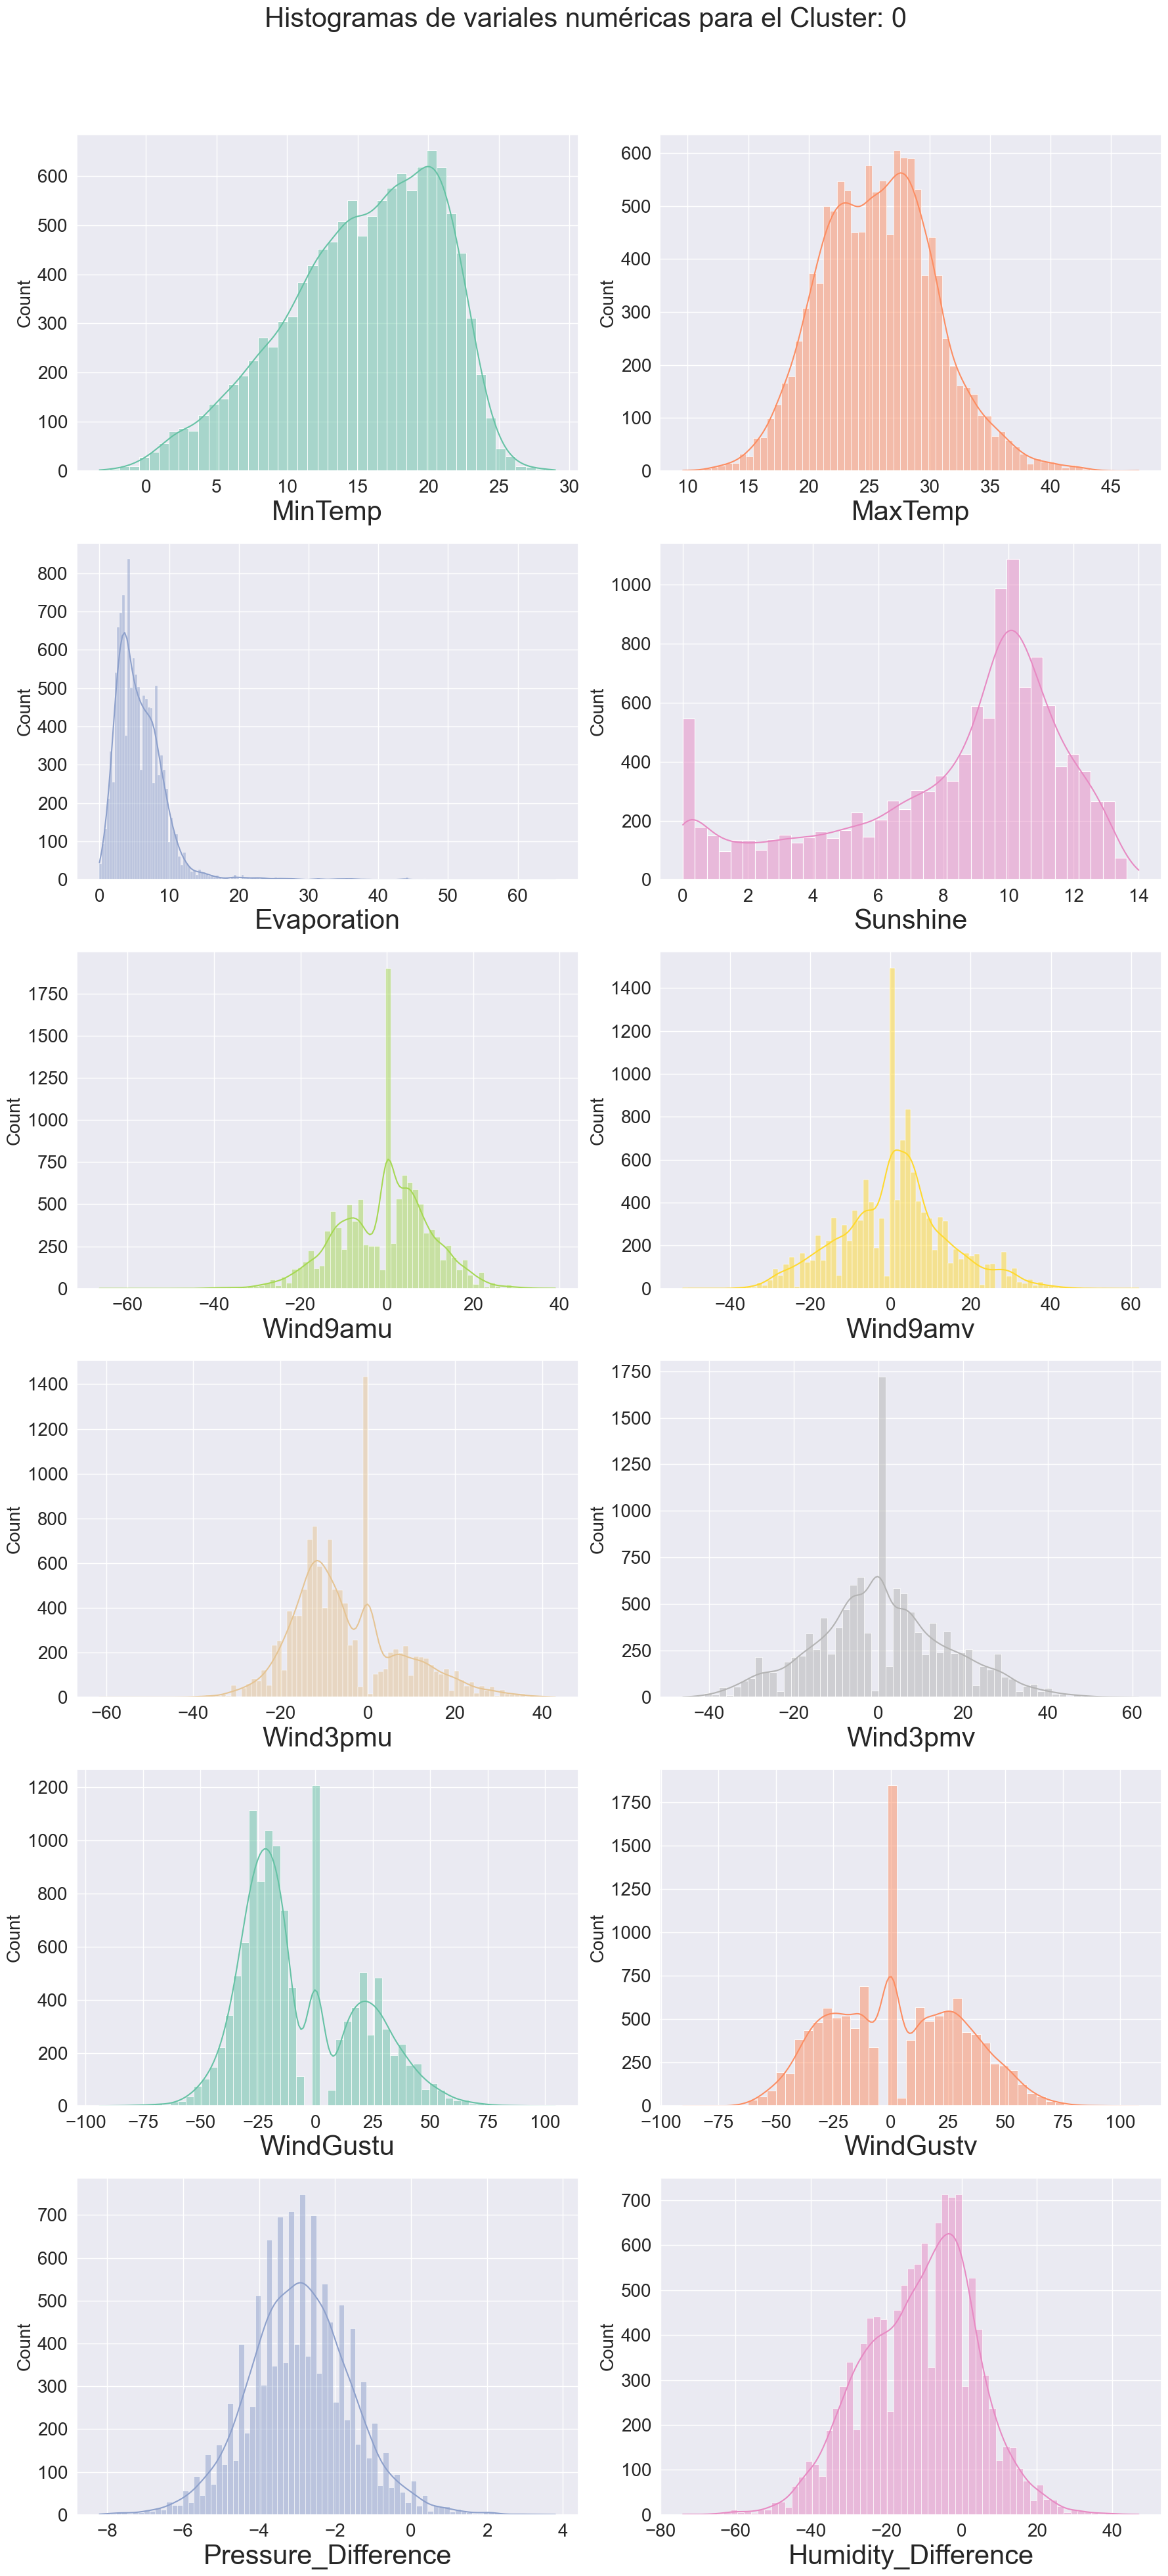

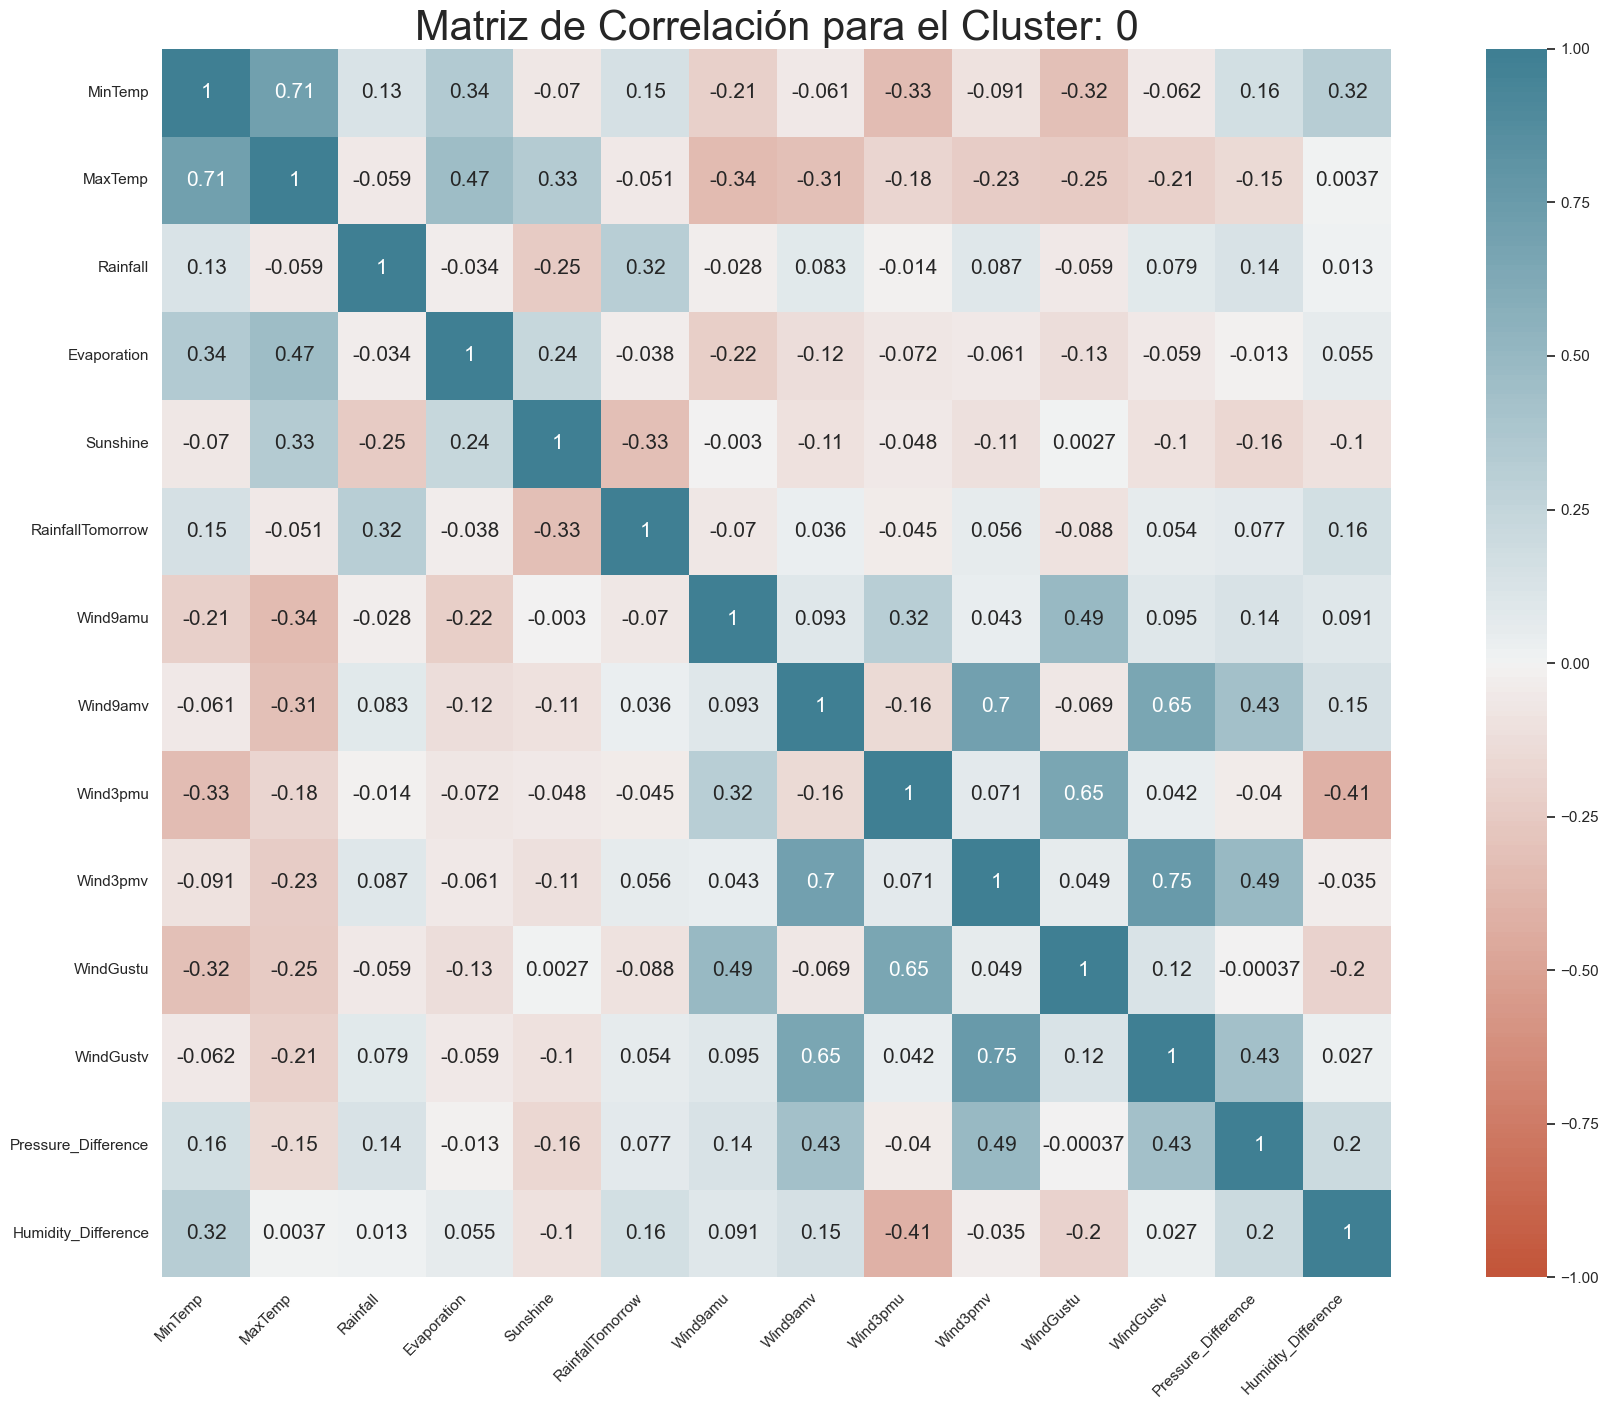

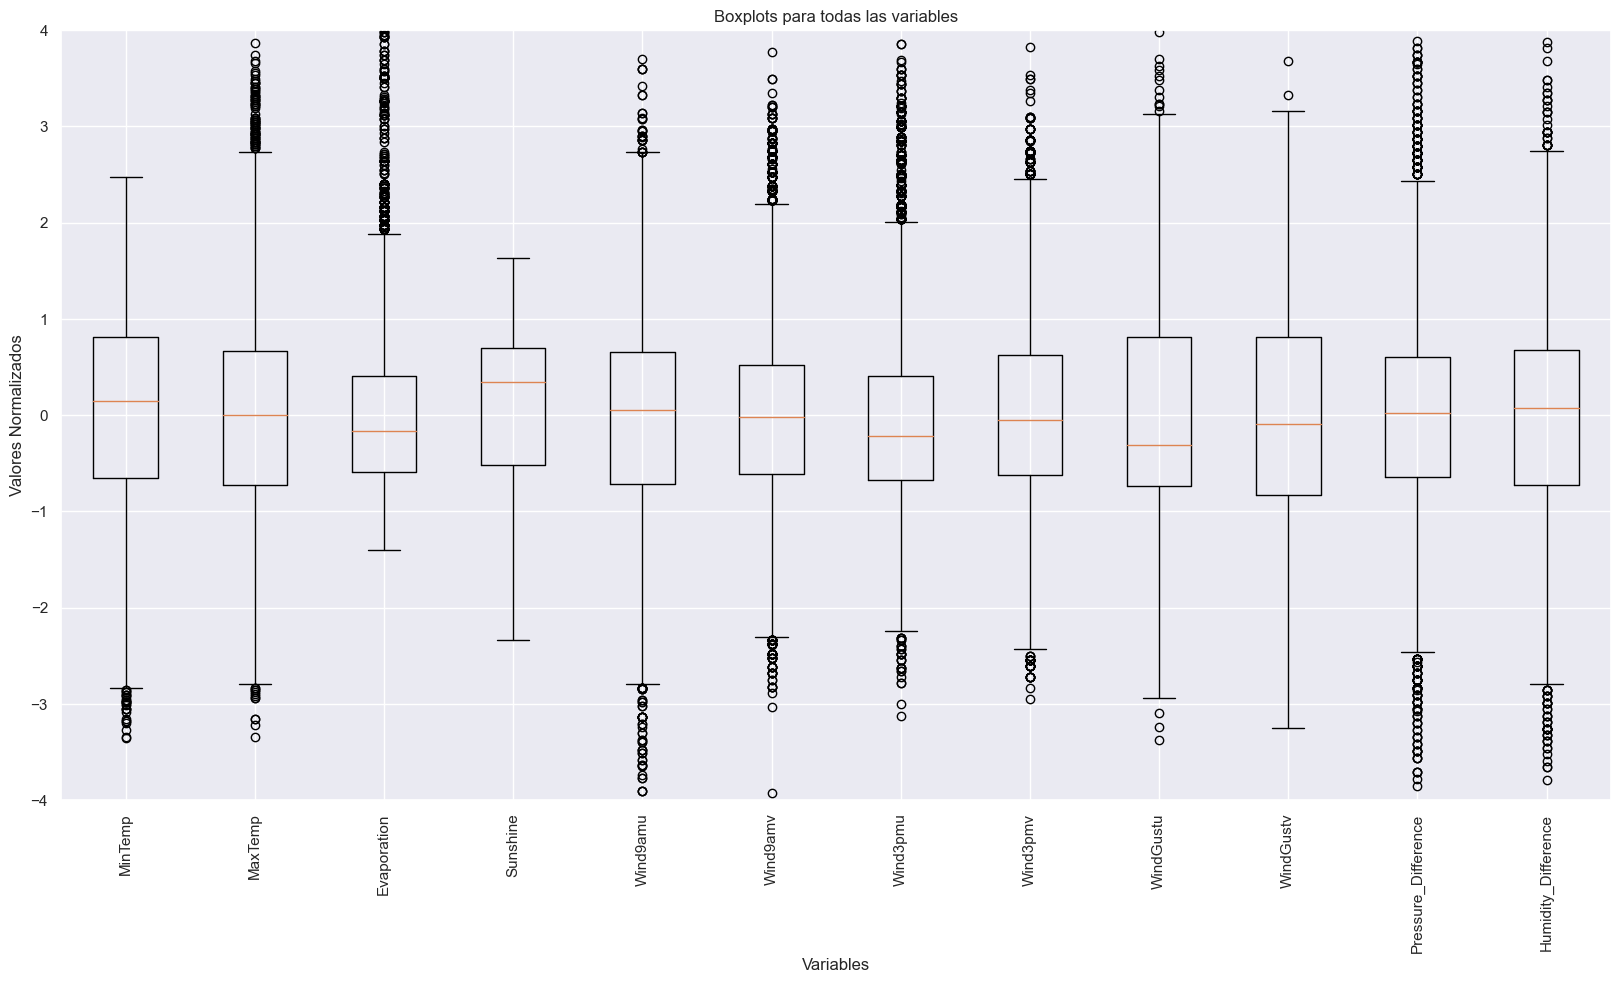

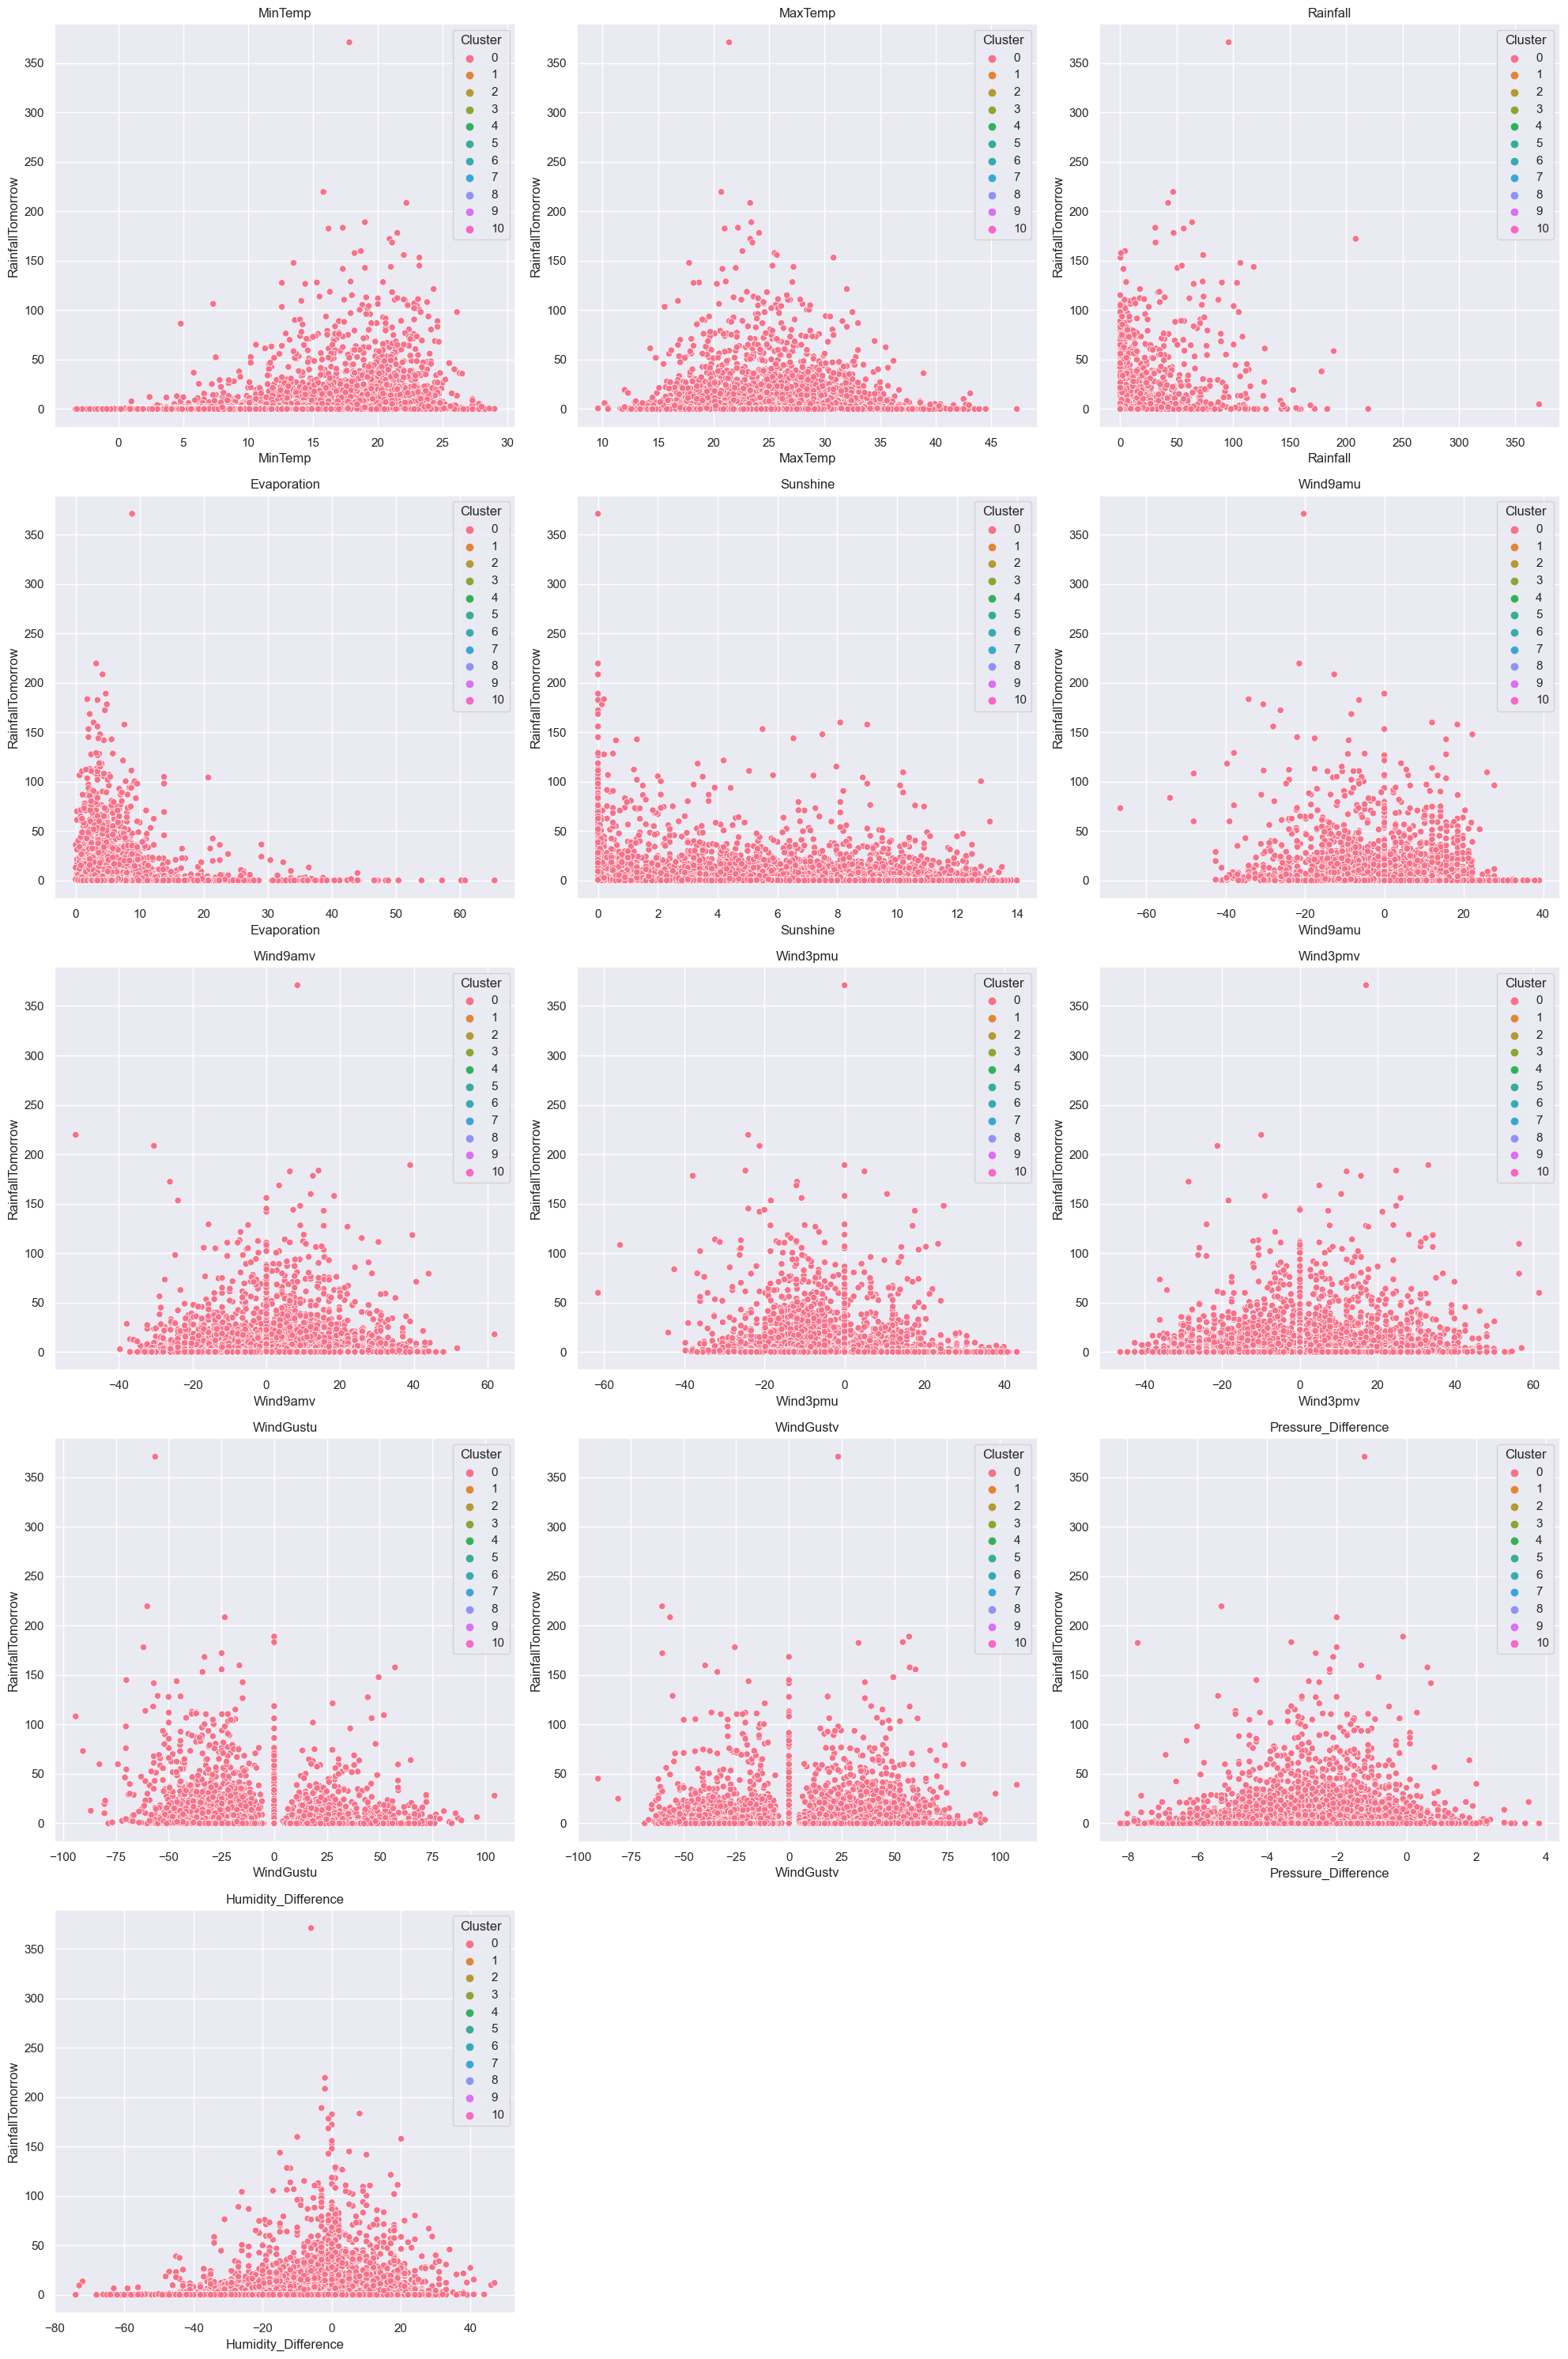

In [309]:
graficos(cluster_dataframe(df,0))

Y también tenemos un método que nos permite ver los boxplot para un mes particular, en caso de que sea necesario.

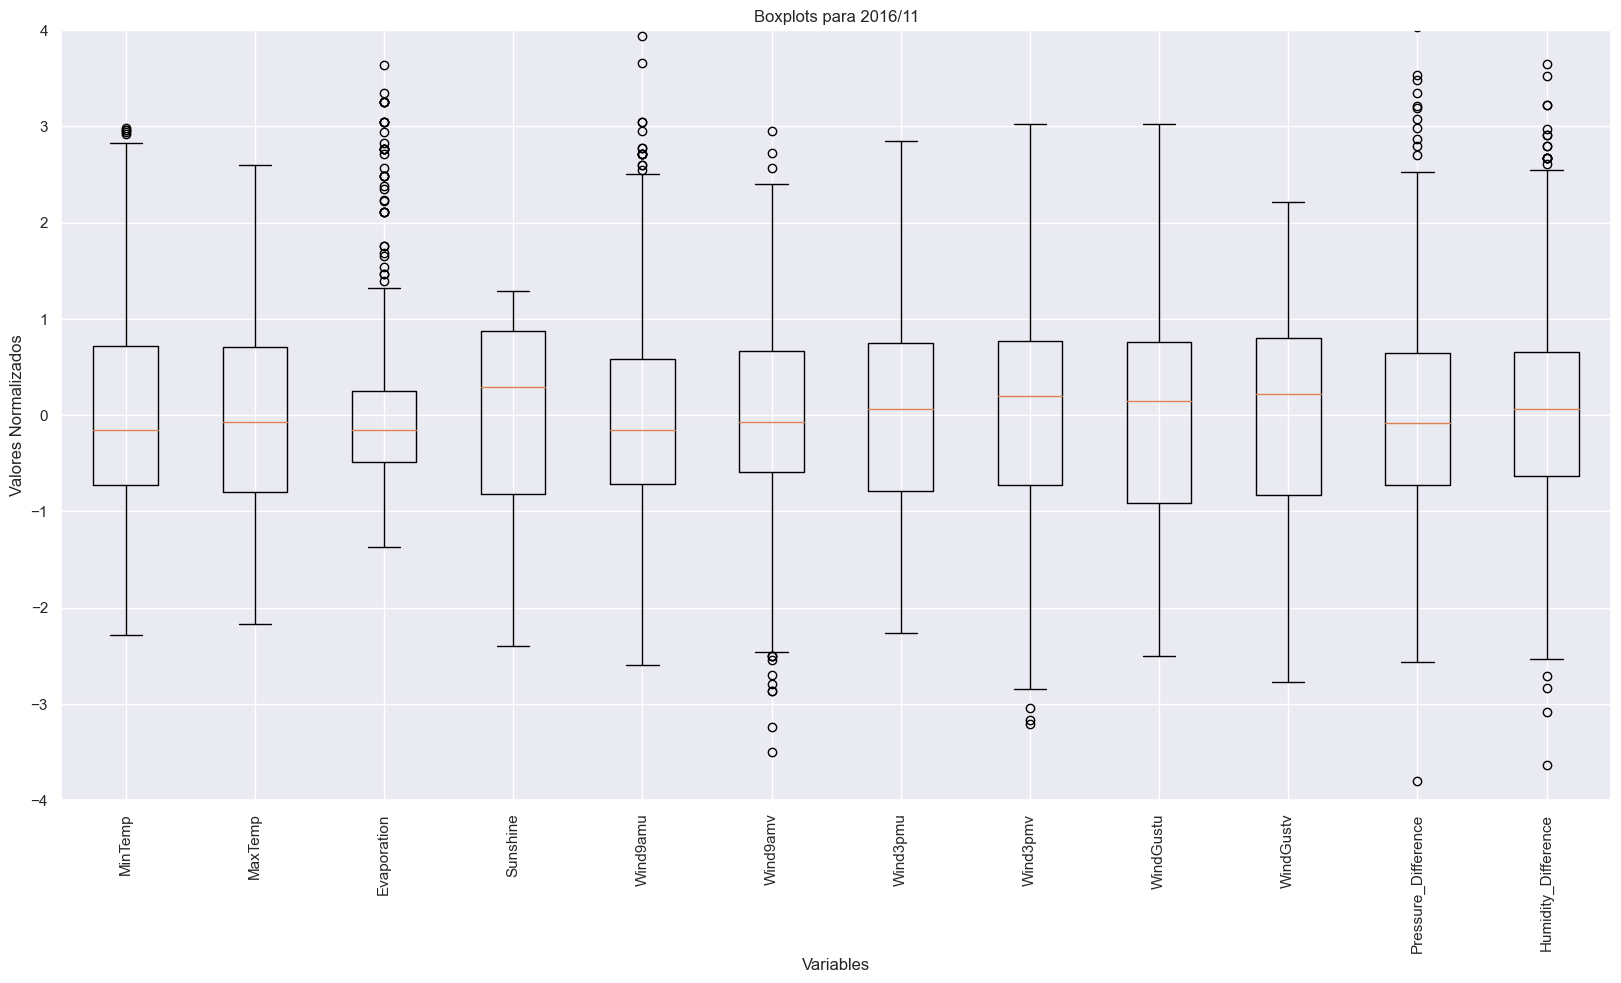

In [310]:
date_boxplots(df, year=2016, month=11)

## Eliminación de Outliers ##
Diseñamos una función que recibe el dataframe y nos elimina del mismo aquellos registros que presentan outliers en alguna de las variables númericas teniendo en cuenta un threshold que puede ser modificado para hacerlo mas o menos restrictivo.

In [378]:
def remove_outliers(df, threshold=2):
    cleaned_df = df.copy()
    columns = df.drop(['RainTomorrow','RainfallTomorrow','RainToday','Rainfall'],axis=1).select_dtypes(include=[float, int])
    for column in columns:
        if column in df.columns:
            # Calcular el rango intercuartílico (IQR)
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            # Definir los límites para identificar valores atípicos
            lower_limit = Q1 - threshold * IQR
            upper_limit = Q3 + threshold * IQR

            # Eliminar valores atípicos
            cleaned_df = cleaned_df[(cleaned_df[column] >= lower_limit) & (cleaned_df[column] <= upper_limit)]

    return cleaned_df

#cleaned_df = df.copy()
cleaned_df = remove_outliers(df)
print(len(df))
print(len(cleaned_df))

139738
134857


In [325]:
cleaned_df.describe()

MinTemp        MaxTemp       Rainfall    Evaporation  \
count  125854.000000  125854.000000  125854.000000  125854.000000   
mean       12.067245      23.203352       2.140601       5.026185   
std         6.297345       6.824412       7.619623       3.050994   
min        -5.900000       2.500000       0.000000       0.000000   
25%         7.500000      18.000000       0.000000       2.600000   
50%        11.800000      22.600000       0.000000       4.533333   
75%        16.600000      28.100000       0.600000       7.000000   
max        30.200000      43.600000     371.000000      14.433333   

            Sunshine  RainfallTomorrow       Wind9amu       Wind9amv  \
count  125854.000000     125854.000000  125854.000000  125854.000000   
mean        7.578619          2.213022      -0.391600       0.019645   
std         3.711849          7.908538      10.085188      10.812480   
min         0.000000          0.000000     -26.162951     -28.640266   
25%         4.900000          0.000000      -7.000000      -6.505618   
50%         8.400000          0.000000      -0.000000       0.000000   
75%        10.500000          0.600000       6.363961       7.000000   
max        14.500000        371.000000      26.666667      28.640266   

           Wind3pmu      Wind3pmv     WindGustu     WindGustv  \
count  1.258540e+05  1.258540e+05  1.258540e+05  1.258540e+05   
mean   4.498362e-01  9.479240e-01  1.321989e+00  2.095217e+00   
std    1.397589e+01  1.363007e+01  2.860434e+01  2.804597e+01   
min   -4.249846e+01 -4.065070e+01 -9.300000e+01 -9.300000e+01   
25%   -1.016267e+01 -9.184402e+00 -2.333452e+01 -2.121320e+01   
50%   -7.347881e-16  3.122849e-15 -3.071822e-15  6.796790e-15   
75%    1.060660e+01  1.100000e+01  2.474874e+01  2.616295e+01   
max    4.434622e+01  4.300000e+01  9.800000e+01  9.800000e+01   

       Pressure_Difference  Humidity_Difference  
count        125854.000000        125854.000000  
mean             -2.502215           -18.082963  
std               1.693422            15.435206  
min              -7.271429           -61.000000  
25%              -3.700000           -29.000000  
50%              -2.600000           -18.000000  
75%              -1.400000            -7.000000  
max               2.300000            27.000000

In [326]:
cleaned_df.isna().sum()

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall               0
Evaporation            0
Sunshine               0
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
Cluster                0
Wind9amu               0
Wind9amv               0
Wind3pmu               0
Wind3pmv               0
WindGustu              0
WindGustv              0
Pressure_Difference    0
Humidity_Difference    0
Estado_Cielo           0
dtype: int64

## Análisis de Balance ##
Para analizar el balance necesitamos determinar si la distribución de las variables target, en este caso categóricas esta uniformemente distribuida. Para eso diseñamos el siguiente método. Pretendemos que los scores estén cerca de 0.5 lo que representaría una distribución uniforme de los datos.

In [341]:
def check_balance(df, target_columns):

    balance_scores = {}

    for column in target_columns:
        class_counts = df[column].value_counts()
        num_classes = len(class_counts)
        max_count = class_counts.max()
        balance_score = max_count / len(df)
        balance_scores[column] = balance_score

    return balance_scores

target_columns = ["RainTomorrow"]
balance_scores = check_balance(cleaned_df, target_columns)
print("Balance Scores:")
for column, score in balance_scores.items():
    print(f"{column}: {score}")

Balance Scores:
RainTomorrow: 0.7872058099067173


Dado que el valor de balance ronda el 0.8, el target RainTomorrow presentan una distribución no uniforme para sus respectivos valores. Esto quiere decir que el dataset no está balanceado.

In [328]:
cleaned_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'RainToday', 'RainTomorrow', 'RainfallTomorrow', 'Cluster',
       'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
       'WindGustv', 'Pressure_Difference', 'Humidity_Difference',
       'Estado_Cielo'],
      dtype='object')

## Selección de características y Estandarización ##

Para predecir la lluvia del día siguiente, decidimos trabajar con las variablas de temperatura mínima y máxima, la lluvia del día la evaporación y luz solar.

In [336]:
def dataframe_normalized(df):
    df_normalized = df.copy()
    skystate = {
        'Despejado' :               0,
        'Parcialmente Nublado' :    1,
        'Nublado' :                 2,
        'Muy Nublado' :             3
    }
    scaler = StandardScaler()
    df_normalized[[ 'MinTemp', 'MaxTemp', 'Evaporation',
                    'Sunshine',
                    'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
                    'WindGustv', 'Pressure_Difference','Humidity_Difference']] = scaler.fit_transform(df_normalized[[ 
                                                                                        'MinTemp', 'MaxTemp', 'Evaporation',
                                                                                        'Sunshine',
                                                                                        'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
                                                                                        'WindGustv', 'Pressure_Difference',
                                                                                        'Humidity_Difference']])
    df_normalized['Estado_Cielo']=df_normalized['Estado_Cielo'].map(skystate)
    return df_normalized

In [353]:
normalizado = dataframe_normalized(cleaned_df)
normalizado

Date Location   MinTemp   MaxTemp  Rainfall  Evaporation  \
0      2008-12-01   Albury  0.201813 -0.041505       0.6     0.665009   
1      2008-12-02   Albury -0.746456  0.272563       0.0     0.820308   
2      2008-12-03   Albury  0.122791  0.358218       0.0     0.230173   
3      2008-12-04   Albury -0.461975  0.686563       0.0     0.199113   
4      2008-12-05   Albury  0.849797  1.300424       1.0     0.354412   
...           ...      ...       ...       ...       ...          ...   
144980 2016-04-19    Uluru  0.217617  1.714424       0.0     1.379383   
144981 2016-04-20    Uluru  1.055255  1.214769       0.0     0.882427   
144985 2016-04-24    Uluru -0.003645  0.586632       0.0     0.944547   
144986 2016-04-25    Uluru -0.398757  0.800770       0.0     0.820308   
144987 2016-04-26    Uluru -0.177495  1.328976       0.0     0.882427   

        Sunshine RainToday RainTomorrow  RainfallTomorrow Cluster  Wind9amu  \
0       0.682619        No           No               0.0       5  1.863742   
1      -0.016234        No           No               0.0       5  0.161849   
2      -0.231266        No           No               0.0       5  1.771595   
3      -0.473176        No           No               1.0       5 -0.695941   
4       1.569624        No           No               0.2       5 -0.575135   
...          ...       ...          ...               ...     ...       ...   
144980  0.897650        No           No               0.0       8 -0.808529   
144981  0.628861        No           No               0.0       8  0.020796   
144985  0.924529        No           No               0.0       8 -1.852130   
144986  0.924529        No           No               0.0       8 -1.177118   
144987  0.924529        No           No               0.0       8 -0.992824   

        Wind9amv  Wind3pmu  Wind3pmv  WindGustu  WindGustv  \
0       0.002972  1.488890 -0.726805   1.425604  -0.073504   
1      -0.318724  1.360420  0.522889   1.312151  -0.657755   
2       0.002972  1.617361  0.631558   1.374741   0.537303   
3       0.680065 -0.678498 -0.074791  -0.639705  -0.662352   
4      -0.230217  0.930517 -1.078762   1.323983  -0.073504   
...          ...       ...       ...        ...        ...   
144980  0.002972  0.712052 -0.074791   0.905311   0.338127   
144981  1.482827 -0.986855 -1.028564   0.337006   0.920261   
144985 -0.729907 -1.373773 -0.074791  -1.114936  -0.073504   
144986  0.002972 -0.292214 -0.665079  -1.081063  -0.073504   
144987  0.002972  1.127170 -1.279557  -0.064846  -1.218544   

        Pressure_Difference  Humidity_Difference  Estado_Cielo  
0                  1.009127            -1.958345             3  
1                 -0.197279            -0.080380             2  
2                  1.941349             0.608207             2  
3                 -1.294011            -0.706369             3  
4                 -1.294011            -1.958345             3  
...                     ...                  ...           ...  
144980            -0.361789            -0.017781             1  
144981            -0.197279            -0.142979             3  
144985            -1.294011            -0.205578             0  
144986            -1.184338             0.170015             0  
144987            -1.348848             0.107416             1  

[134857 rows x 20 columns]

In [429]:
skystate = {
    'Despejado' :               0,
    'Parcialmente Nublado' :    1,
    'Nublado' :                 2,
    'Muy Nublado' :             3
}
x=cleaned_df.drop(['RainToday','RainTomorrow','RainfallTomorrow','Date','Location','Cluster'],axis=1)
x['Estado_Cielo'] = x['Estado_Cielo'].map(skystate)
x=x[['MinTemp', 'MaxTemp', 'Evaporation',
    'Sunshine',
    'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
    'WindGustv', 'Pressure_Difference','Humidity_Difference','Estado_Cielo']].values.reshape(-1,13)
y=cleaned_df['RainfallTomorrow'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Regresión Lineal #

## Linear Regression ##

### Global Regression ###

In [424]:
# Crear un modelo de regresión lineal
lr = LinearRegression(fit_intercept=True)

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = lr.predict(X_test)

# Calcular métricas de evaluación
r2 = lr.score(X_test, y_test)
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred - y_test))
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100  # Multiplicado por 100 para obtener el porcentaje
rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))

# Imprimir métricas
print('R2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('MAPE: ', mape)
print('RMSLE: ', rmsle)
print('---------------------------------------------')

R2:  0.12178390193490307
MSE:  63.865319047137504
RMSE:  7.991578007323554
MAE:  3.7112771585041164
MAPE:  inf
RMSLE:  nan
---------------------------------------------


C:\Users\guido\AppData\Local\Temp\ipykernel_15684\1157705154.py:15: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100  # Multiplicado por 100 para obtener el porcentaje
C:\Users\guido\AppData\Local\Temp\ipykernel_15684\1157705154.py:16: RuntimeWarning: invalid value encountered in log1p
  rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_test)) ** 2))


### Clustering Regression ###

In [ ]:
for i in range(11):
    cldf=cluster_dataframe(cleaned_df,i)
    if len(cldf)==0:
        continue
    print(len(cldf))
    x=cldf.drop(['RainToday','RainTomorrow','RainfallTomorrow','Date','Location','Cluster'],axis=1)
    x['Estado_Cielo'] = x['Estado_Cielo'].map(skystate)
    x=x[['MinTemp', 'MaxTemp', 'Evaporation',
        'Sunshine',
        'Wind9amu', 'Wind9amv', 'Wind3pmu', 'Wind3pmv', 'WindGustu',
        'WindGustv', 'Pressure_Difference','Humidity_Difference','Estado_Cielo']].values.reshape(-1,13)
    y=cldf['RainfallTomorrow'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    lr = LinearRegression(fit_intercept=True)
    lr.fit(X_train,y_train)
    y_pred=lr.predict(X_test)
    print('Cluster: ',i)
    print('R2: ',lr.score(X_test,y_test))
    print('MSE: ',np.mean((y_pred-y_test)**2))
    print('RMSE: ',np.sqrt(np.mean((y_pred-y_test)**2)))
    print('MAE: ',np.mean(np.abs(y_pred-y_test)))
    print('MAPE: ',np.mean(np.abs((y_pred-y_test)/y_test)))
    print('---------------------------------------------')

## Gradient Descent ##

In [425]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

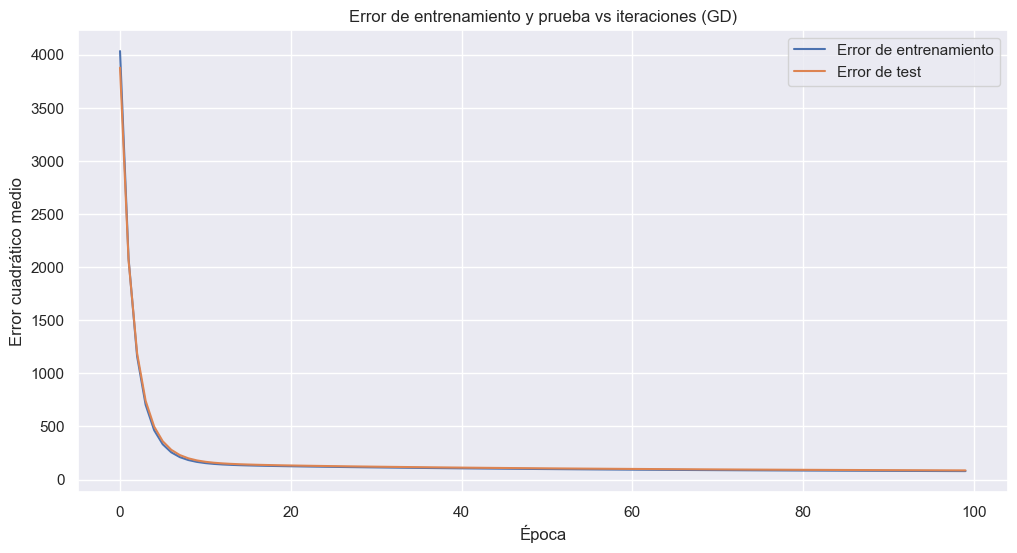

R2:  0.12178390193490307
MSE:  63.865319047137504
RMSE:  7.991578007323554
MAE:  3.7112771585041164
MAPE:  inf
---------------------------------------------


C:\Users\guido\AppData\Local\Temp\ipykernel_15684\3705405407.py:6: RuntimeWarning: divide by zero encountered in true_divide
  print('MAPE: ',np.mean(np.abs((y_pred-y_test)/y_test)))


In [426]:
W = gradient_descent(X_train, y_train, X_test, y_test, lr=0.0001, epochs=100)
print('R2: ',lr.score(X_test,y_test))
print('MSE: ',np.mean((y_pred-y_test)**2))
print('RMSE: ',np.sqrt(np.mean((y_pred-y_test)**2)))
print('MAE: ',np.mean(np.abs(y_pred-y_test)))
print('MAPE: ',np.mean(np.abs((y_pred-y_test)/y_test)))
print('---------------------------------------------')

C:\Users\guido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


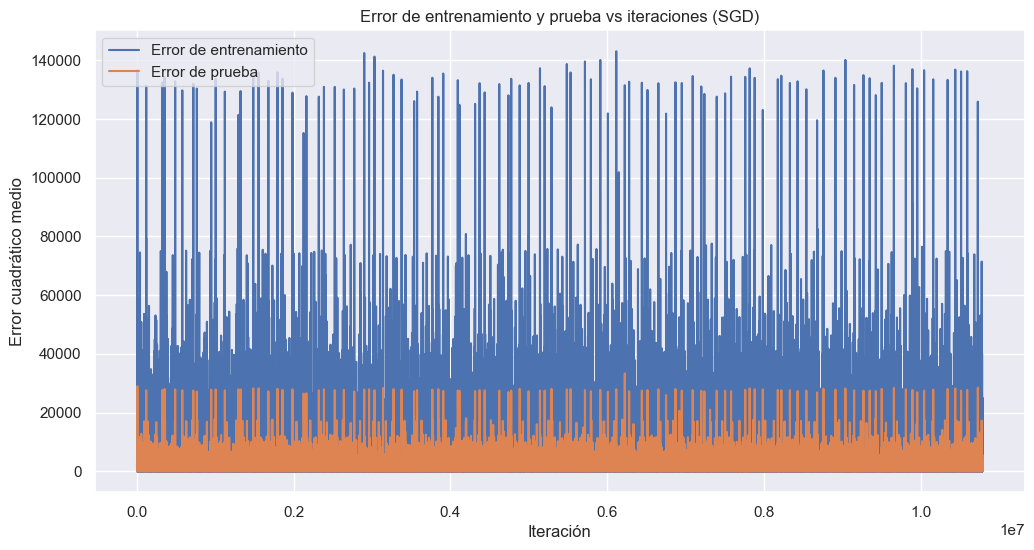

In [430]:
W = stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=100)

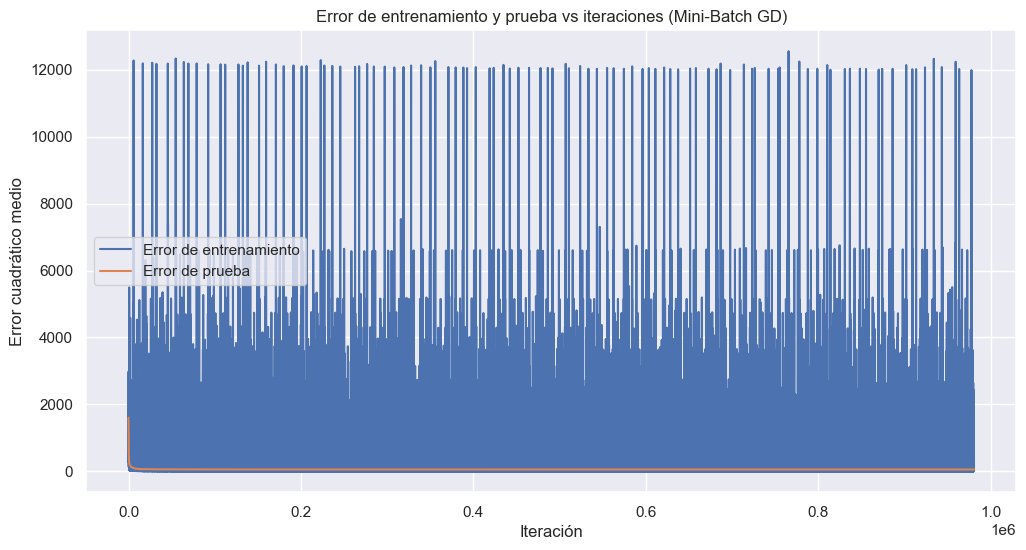

In [432]:
W = mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.000001, epochs=100)

## Regularización ##
